# ADA Project - DataBrewers

The aim of this project is to analyze beer preference shifts across seasons and events, with a focus on understanding consumer trends in taste, aroma, palate, and appearance. By examining variation in ratings for beer style and alcohol content among US users, and comparing different states with varying weather conditions, we seek to identify seasonal trends. To deepen our understanding, we will conduct sentiment analysis to capture the tone of reviews and references to seasons, weather, or events, and correlate these insights with ratings. Our findings will provide actionable insights for professionals (brewers, marketers, etc.) by highlighting customer preferences throughout the year. Understanding these seasonal trends enables brewers to adjust product offerings to align more closely with consumer demand. As a conclusion of to our research, we could suggest the best beer that would be the perfect match for each season/festivity, in the form of a time fresco. 


## Data preprocessing

In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import wordcloud
import nltk
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


### Loading

In [2]:
import sys
sys.path.append('src')

from data.dataloader import load_matched_beer_data, load_beer_advocate_data, load_rate_beer_data

# Load the matched beer data
ratings_merged, users_approx, users_merged, beers_merged, breweries_merged = load_matched_beer_data()

# Load the BeerAdvocate data
beers_ba, reviews_ba, users_ba, breweries_ba, ratings_ba = load_beer_advocate_data()

# Load the RateBeer data
beers_rb, reviews_rb, users_rb, breweries_rb, ratings_rb = load_rate_beer_data()

### Dataset comparaison and selection 
In this following section, we compare the two datasets : BeerAdvocate and RateBeer by looking at the number of users, beers, ratings and reviews. 

**Number of users**

In [3]:
# We prompt the number of users in each dataset
nb_users_rb = len(users_rb)
nb_users_ba = len(users_ba)

print("The RateBeer dataset have", nb_users_rb, "users.")
print("The BeerAdvocate dataset have", nb_users_ba, "users.")

The RateBeer dataset have 70174 users.
The BeerAdvocate dataset have 153704 users.


**Number of beers**

In [4]:
# We prompt the number of beers in each dataset
nb_beers_rb = len(beers_rb)
nb_beers_ba = len(beers_ba)

print("The RateBeer dataset have", nb_beers_rb, "beers.")
print("The BeerAdvocate dataset have", nb_beers_ba, "beers.")

The RateBeer dataset have 442081 beers.
The BeerAdvocate dataset have 280823 beers.


**Number of ratings**

In [5]:
# We prompt the numbers of ratings in each dataset using the nbr_ratings column of the beers dataset and summing them
nb_ratings_rb = beers_rb['nbr_ratings'].sum()
nb_ratings_ba = beers_ba['nbr_ratings'].sum()

print("The RateBeer dataset have", nb_ratings_rb, "ratings.")
print("The BeerAdvocate dataset have", nb_ratings_ba, "ratings.")

The RateBeer dataset have 7122074 ratings.
The BeerAdvocate dataset have 8393032 ratings.


**Numbers of reviews**


The reviews datasets are not in a user-friendly format: all data is stored in a single column, with each review’s information spread across 16 rows. This structure requires reshaping to extract and organize the information into distinct columns for easier analysis.

In [6]:
import sys
sys.path.append('src')

from src.scripts.script import format_data

reviews_ba = format_data(reviews_ba, "review_id")
reviews_rb = format_data(reviews_rb, "review_id")

In [7]:
nb_reviews_rb = len(reviews_rb)
nb_reviews_ba = len(reviews_ba)

print("The RateBeer dataset have", nb_reviews_rb, "reviews.")
print("The BeerAdvocate dataset have", nb_reviews_ba, "reviews.")

The RateBeer dataset have 7122074 reviews.
The BeerAdvocate dataset have 2589586 reviews.


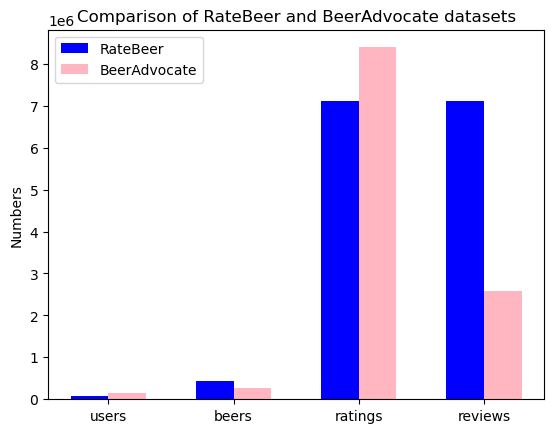

In [8]:
labels = ["users", "beers", "ratings", "reviews"]

rb_counts = [nb_users_rb, nb_beers_rb, nb_ratings_rb, nb_reviews_rb]
ba_counts = [nb_users_ba, nb_beers_ba, nb_ratings_ba, nb_reviews_ba]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
bars_rb = ax.bar(x - width/2, rb_counts, width, label='RateBeer', color='blue')
bars_ba = ax.bar(x + width/2, ba_counts, width, label='BeerAdvocate', color='lightpink')

ax.set_ylabel('Numbers')
ax.set_title('Comparison of RateBeer and BeerAdvocate datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [9]:
summary_data = {
    "Metric": ["users", "beers", "ratings", "reviews"],
    "RateBeer": [nb_users_rb, nb_beers_rb, nb_ratings_rb, nb_reviews_rb],
    "BeerAdvocate": [nb_users_ba, nb_beers_ba, nb_ratings_ba, nb_reviews_ba]
}
summary_df = pd.DataFrame(summary_data)
summary_df.style.set_caption("Summary for RateBeer and BeerAdvocate")

The BeerAdvocate dataset provides us with enough reviews and data to perform and we will focus only on this dataset for the rest of the analysis.

1. **The Herding Effect:** As explained in the paper "When Sheep Shop: Measuring Herding Effects in Product Ratings with Natural Experiments" from Gael Lederrey and Robert West, initial ratings can influence the following ones. By focusing on a single dataset, we can better control for this effect within a single user community. Including RateBeer might introduce inconsistent herding effects that could skew comparative analyses.
2. **Inconsistant Rating Standards:** Both BeerAdvocate and RateBeer communities likely develop their own informal standards for beer ratings. Focusing on a single platform like BeerAdvocate allows dor a more cohesive dataset, with users who rate within the same context, minimizing cross-platform variance.
3. **Data Sufficiency:** The BeerAdvocate dataset provides us with enough reviews and data to perform meaningful analysis and draw reliable insights.

### Analysis of users’ countries of origin

In [10]:
# Separate the country and the states
users_ba['country'] = users_ba['location'].str.split(',').str[0]
users_ba['states'] = users_ba['location'].str.split(',').str[1]

In [11]:
missing_countries = users_ba['country'].isna().sum()
total_entries = len(users_ba)
missing_percentage = (missing_countries / total_entries) * 100

print(f"Number of missing 'country' entries: {missing_countries} ({missing_percentage:.2f}%)")

Number of missing 'country' entries: 31279 (20.35%)


In [12]:
# Replace missing 'country' values with a label "Unknown"
users_ba['country'] = users_ba['country'].fillna('Unknown')

# Compute the number of users in the top 5 countries
top5_countries = users_ba['country'].value_counts().nlargest(5)

# Compute the sum of the remaining countries (including 'Unknown' entries if any)
other_countries_count = len(users_ba) - top5_countries.sum()

# Add the "Other" countries count to the series
top_countries = pd.concat([top5_countries, pd.Series({'Other': other_countries_count})])

# Calculate percentages for each country in top_countries
top_countries_percent_ba = (top_countries / len(users_ba) * 100).round(1)

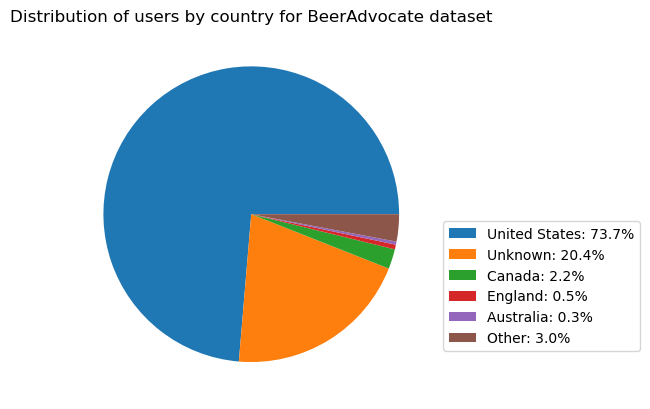

In [13]:
top_countries.plot(kind='pie', labels=None)

# Create legend with country name and percentage
top_countries_labels = [f"{country}: {percent}%" for country, percent in zip(top_countries.index, top_countries_percent_ba)]
plt.legend(labels=top_countries_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title(f'Distribution of users by country for BeerAdvocate dataset')
plt.show()

The majority of the users are from the United States. 

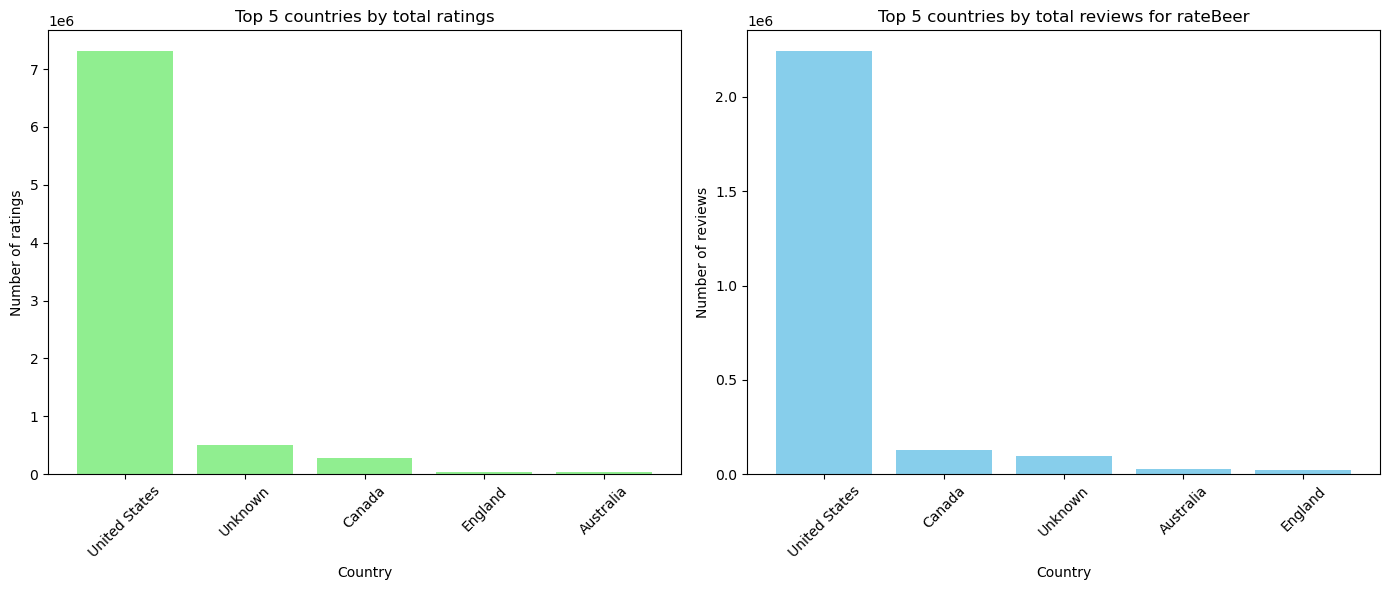

In [14]:
# Convert the number of ratings values to numeric
users_ba['nbr_ratings'] = pd.to_numeric(users_ba['nbr_ratings'], errors='coerce')
users_ba['nbr_reviews'] = pd.to_numeric(users_ba['nbr_reviews'], errors='coerce')

# Group by country and sum the ratings and the reviews
country_ratings = users_ba.groupby('country')['nbr_ratings'].sum().reset_index()
country_reviews = users_ba.groupby('country')['nbr_reviews'].sum().reset_index()

# Get the top 5 countries by number of ratings and reviews
top_countries_ratings = country_ratings.nlargest(5, 'nbr_ratings')
top_countries_reviews = country_reviews.nlargest(5, 'nbr_reviews')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(top_countries_ratings['country'], top_countries_ratings['nbr_ratings'], color='lightgreen')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Number of ratings')
axes[0].set_title('Top 5 countries by total ratings')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(top_countries_reviews['country'], top_countries_reviews['nbr_reviews'], color='skyblue')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Number of reviews')
axes[1].set_title('Top 5 countries by total reviews for rateBeer')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Most of the ratings and reviews are made by american users. 


Therefore, we have chosen to focus on the reviews and ratings published by users based in the United State of America. The reason for this choice is that it is the country where the majority of reviews and ratings are done, and it provides us with enough data to conduct our analysis.



In [15]:
# Keep only users from the US
users = users_ba[users_ba['country'] == 'United States']
print("There are", len(users), "users from the United States in the BeerAdvocate dataset")

# Prompt the number of ratings made by US users using the nb_ratings column of the users dataset and summing them for users where location contains United States 
print("Number of ratings made by US users: ", users[users['country'].str.contains('United States')]['nbr_ratings'].sum())

# Prompt the number of reviews made by US users using the nb_reviews column of the users dataset and summing them for users where location contains United States
print("Number of reviews made by US users: ", users[users['country'].str.contains('United States')]['nbr_reviews'].sum())

There are 113223 users from the United States in the BeerAdvocate dataset
Number of ratings made by US users:  7303870
Number of reviews made by US users:  2241334


In [16]:
# Merge the reviews with user information on location
reviews_ba = reviews_ba.merge(users_ba[['user_id', 'location']], on='user_id', how='left')

In [17]:
# Remove the states to only have the countries
reviews_ba['country'] = reviews_ba['location'].str.split(',').str[0]

# Remove the countries to only have the states
reviews_ba['states'] = reviews_ba['location'].str.split(',').str[1]

# We only keep users from the US
reviews = reviews_ba[reviews_ba['country'] == 'United States']

The reviews dataset contains now the country of origin of the users. 


The ratings datasets are not in a user-friendly format: all data is stored in a single column, with each rating’s information spread across 16 rows. As for the review dataset, it requires reshaping to extract and organize the information into distinct columns for easier analysis. Moreover, as we are only focusing on american users, it also requires filtering based on the location of the user.

In [18]:
# Reshape the ratings dataset
ratings_ba = format_data(ratings_ba, "rating_id")

In [19]:
# Merge the reviews with user information on location
ratings_ba = ratings_ba.merge(users_ba[['user_id', 'location']], on='user_id', how='left')

# Remove the states to only have the countries
ratings_ba['country'] = ratings_ba['location'].str.split(',').str[0]

# Remove the countries to only have the states
ratings_ba['states'] = ratings_ba['location'].str.split(',').str[1]

# We only keep users from the US
ratings = ratings_ba[ratings_ba['country'] == 'United States']

### Data storing 

**Saving the data on local**

In [20]:
reviews.to_csv('data/reviews_processed.csv.gz', index=False, compression='gzip')
ratings.to_csv('data/ratings_processed.csv.gz', index=False, compression='gzip')
users.to_csv('data/users_processed.csv.gz', index=False, compression='gzip')
beers_ba.to_csv('data/beers_ba_processed.csv.gz', index=False, compression='gzip')
breweries_ba.to_csv('data/breweries_ba_processed.csv.gz', index=False, compression='gzip')

**Load the data from local**

In [2]:
reviews = pd.read_csv('data/reviews_processed.csv.gz', compression='gzip')
ratings = pd.read_csv('data/ratings_processed.csv.gz', compression='gzip')
users = pd.read_csv('data/users_processed.csv.gz', compression='gzip')
beers_ba = pd.read_csv('data/beers_ba_processed.csv.gz', compression='gzip')
breweries_ba = pd.read_csv('data/breweries_ba_processed.csv.gz', compression='gzip')

### Analysis of users' states of origin 

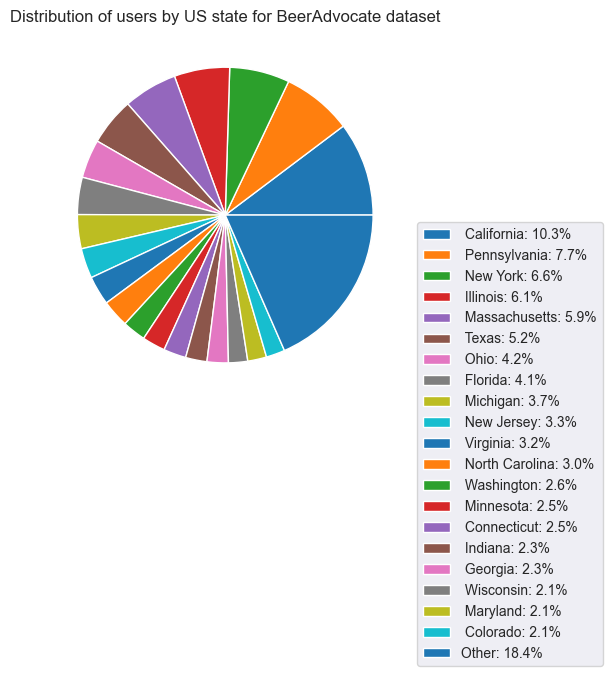

In [3]:
# Compute the number of users in the top 20 states
top20_states = users['states'].value_counts().nlargest(20)

# Compute the sum of the remaining states
other_users_count = len(users) - top20_states.sum()

# Add the "Other" states count to the series
top_states = pd.concat([top20_states, pd.Series({'Other': other_users_count})])

# Calculate percentages for each country in top_countries
top_states_percent = (top_states / len(users) * 100).round(1)

top_states.plot(kind='pie', labels=None)

# Create legend with state name and percentage
top_states_labels = [f"{state}: {percent}%" for state, percent in zip(top_states.index, top_states_percent)]
plt.legend(labels=top_states_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title(f'Distribution of users by US state for BeerAdvocate dataset')
plt.show()

There is considerable diversity in the origins of U.S. users, with 10.3% from California, a generally warmer region, and 7.7% and 6.6% from Pennsylvania and New York, respectively, where colder climates are common.
We decided to regroup the state into 4 categories based on geographical regions in the United States:
- South: Texas, Georgia, Florida, ...
- West: California, Colorado, Washington, ...
- Northeast: New York, New Jersey, Pennsylvania, ...
- Midwest: Illinois, Michigan, Ohio, ... 

Source: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf 

In [3]:
regions = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 
                  'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 
                'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin'],
    'South': ['Alabama', 'Arkansas', 'Delaware', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 
              'Maryland', 'Mississippi', 'North Carolina', 'Oklahoma', 'South Carolina', 
              'Tennessee', 'Texas', 'Virginia', 'West Virginia'],
    'West': ['Alaska', 'Arizona', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 
             'Nevada', 'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming']
}

# Assign region based on state
def assign_region(state):
    # Remove spaces
    state = state.strip().title()
    
    for region, states in regions.items():
        if state in states:
            return region
    return 'Other'

users['region'] = users['states'].apply(assign_region)


In [5]:
# Count the number of users in each region
region_counts = users['region'].value_counts()
print(region_counts)

region
Northeast    32903
South        30359
Midwest      28002
West         21959
Name: count, dtype: int64


There are no users that don't have an assigned region. 

In [4]:
ratings = ratings.merge(users[['user_id', 'region']], on='user_id', how='left')
reviews = reviews.merge(users[['user_id', 'region']], on='user_id', how='left')

### Analysis of beer style

In [5]:
from src.scripts.script import get_style_map

stylemap = get_style_map()

In [6]:
#replace the style with the mapped style ()
#remove American from the style

beers_ba['style'] = beers_ba['style'].str.replace('American ', '')
beers_ba['style'] = beers_ba['style'].str.replace('German ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Czech ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Belgian ', '')
beers_ba['style'] = beers_ba['style'].str.replace('English ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Euro ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Scottish ', '')
beers_ba['style'] = beers_ba['style'].str.replace('Double / Imperial ', '')
beers_ba['style'] = beers_ba['style'].str.replace(' (APA)', '')

beers_ba['style_simp'] = beers_ba['style'].replace(stylemap)   

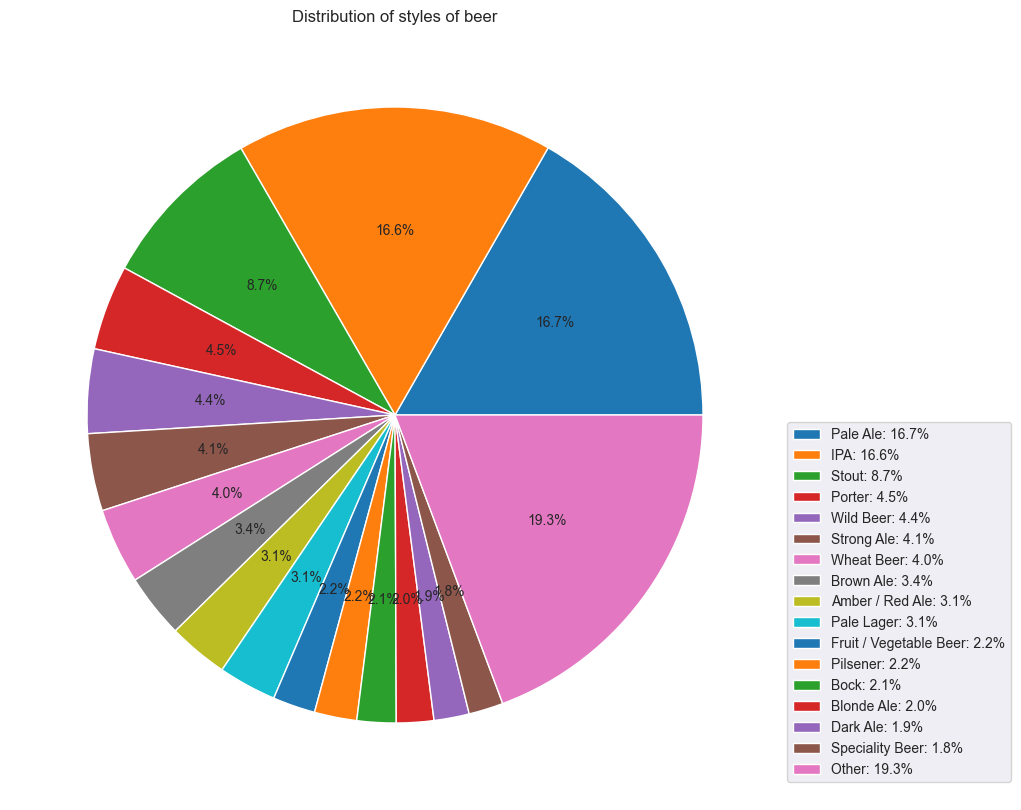

In [7]:
beers_ba['style_simp'] = beers_ba['style'].replace(stylemap)

style_count = beers_ba['style_simp'].value_counts()

# Determine the threshold for 'Other' category 
threshold = 5000  
other_count = style_count[style_count < threshold].sum()  
top_styles = style_count[style_count >= threshold]  
top_styles = pd.concat([top_styles, pd.Series({'Other': other_count})])

top_styles_percent = (top_styles / top_styles.sum() * 100).round(1)

top_styles.plot(kind='pie', labels=None, autopct='%1.1f%%', figsize=(10, 10))

top_styles_labels = [f"{style}: {percent}%" for style, percent in zip(top_styles.index, top_styles_percent)]
plt.legend(labels=top_styles_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title('Distribution of styles of beer')
plt.show()

In [8]:
ratings_count = ratings['beer_id'].value_counts()

In [9]:
beer_counts_df = ratings_count.reset_index().rename(columns={'index': 'beer_id'})
beer_counts_df['beer_id'] = beer_counts_df['beer_id'].astype(int)
beers = beers_ba.reset_index()
beers['beer_id'] = beers['beer_id'].astype(int)

# Merge the series DataFrame with beer_ba on beer_id
result = beer_counts_df.merge(beers, on='beer_id', how='left')

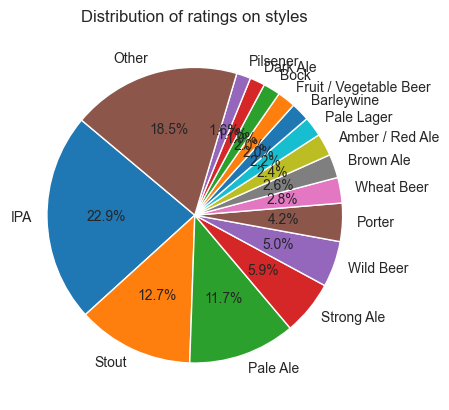

In [12]:
# Group by 'style' to get the total count for each
style_counts = result.groupby('style_simp')['count'].sum().sort_values(ascending=False)

# Define a threshold for the 'Other' category
threshold = 100000 
other_count = style_counts[style_counts < threshold].sum()
top_styles = style_counts[style_counts >= threshold]

top_styles = pd.concat([top_styles, pd.Series({'Other': other_count})])

plt.pie(top_styles, labels=top_styles.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of ratings on styles')

plt.show()

In [13]:
total_count = style_count.sum()
threshold = 0.02 * total_count

# Filter styles with a count greater than or equal to 2% of the total count
beer_styles_above_2_percent = style_count[style_count >= threshold].index.tolist()

In [10]:
reviews = reviews.merge(beers[['beer_id','style_simp']], on='beer_id', how='left')
ratings = ratings.merge(beers[['beer_id','style_simp']], on='beer_id', how='left')

### Analysis of the beer percentage of alcohol by volume

In [15]:
reviews['abv'].describe()

count    2.181501e+06
mean     7.254056e+00
std      2.385050e+00
min      1.000000e-02
25%      5.400000e+00
50%      6.800000e+00
75%      8.700000e+00
max      6.750000e+01
Name: abv, dtype: float64

We can categorize beer types based on their Alcohol by Volume (ABV) percentage as follows:
- **low ABV**: 0-25% quantile → ABV up to 5.5%
- **medium ABV**: 25%-75% quantile → ABV between 5.5% and 8.8%
- **high ABV**: 75%-100% quantile → ABV higher than 8.8%

In [11]:
# Calculate the quantiles
abv_quantiles = reviews['abv'].quantile([0.25, 0.5, 0.75])

def categorize_abv(abv_value):
    if abv_value <= abv_quantiles[0.25]:  # Low ABV
        return 'low'
    elif abv_value <= abv_quantiles[0.75]:  # Medium ABV
        return 'middle'
    else:  # High ABV
        return 'high'

reviews['abv_category'] = reviews['abv'].apply(categorize_abv)
ratings['abv_category'] = ratings['abv'].apply(categorize_abv)

### Analysis of the publication timing of user reviews

In [12]:
# Extract the year, month, and day
reviews['date']  = pd.to_datetime(reviews['date'], unit='s', errors='coerce')
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month
reviews['day'] = reviews['date'].dt.day

In [13]:
# Extract the year, month, and day
ratings['date']  = pd.to_datetime(ratings['date'], unit='s', errors='coerce')
ratings['year'] = ratings['date'].dt.year
ratings['month'] = ratings['date'].dt.month
ratings['day'] = ratings['date'].dt.day

In [14]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    elif month in [12, 1, 2]:
        return 'Winter'

In [15]:
# Separate the reviews by seasons
reviews['season'] = reviews['month'].apply(get_season)

# Separate the ratings by seasons
ratings['season'] = ratings['month'].apply(get_season)

**Over the years**

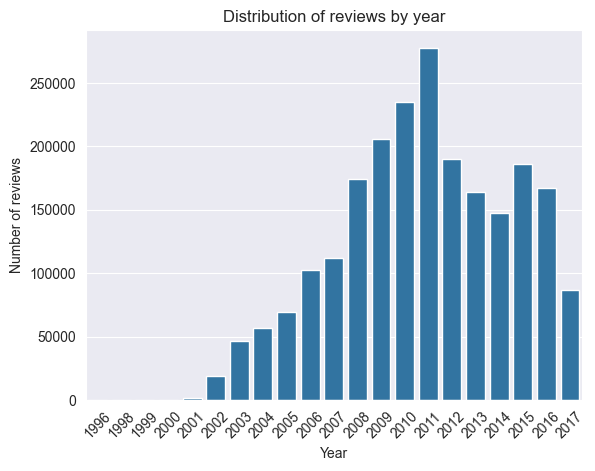

In [21]:
# Plot yearly review counts

sns.countplot(data=reviews, x='year', legend=False)
plt.title('Distribution of reviews by year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

We can see that before 2002, there are few reviews given by users on the BeerAdvocate website. We can choose a threshold of a minimum of 70'000 reviews by year to have enough reviews published by year to analyze the change over a year.

In [16]:
# Count the number of reviews by year
reviews_per_year = reviews['year'].value_counts()

# Filter to keep only years with more than 70'000 reviews
years_above_threshold = reviews_per_year[reviews_per_year > 70000].index
reviews = reviews[reviews['year'].isin(years_above_threshold)]
ratings = ratings[ratings['year'].isin(years_above_threshold)]

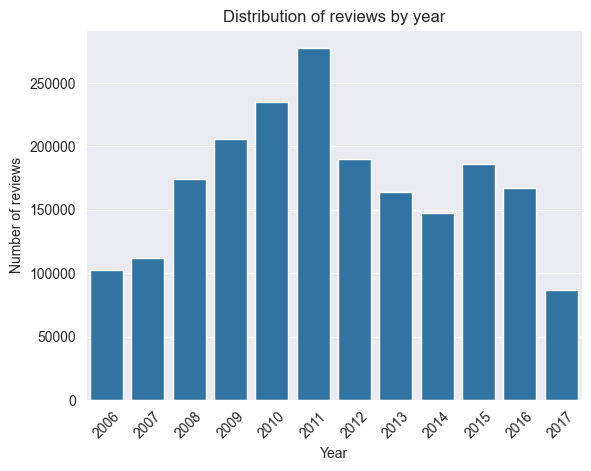

In [23]:
sns.countplot(data=reviews, x='year')
plt.title('Distribution of reviews by year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

We now have only reviews published between 2006 and 2017

**Across the seasons**

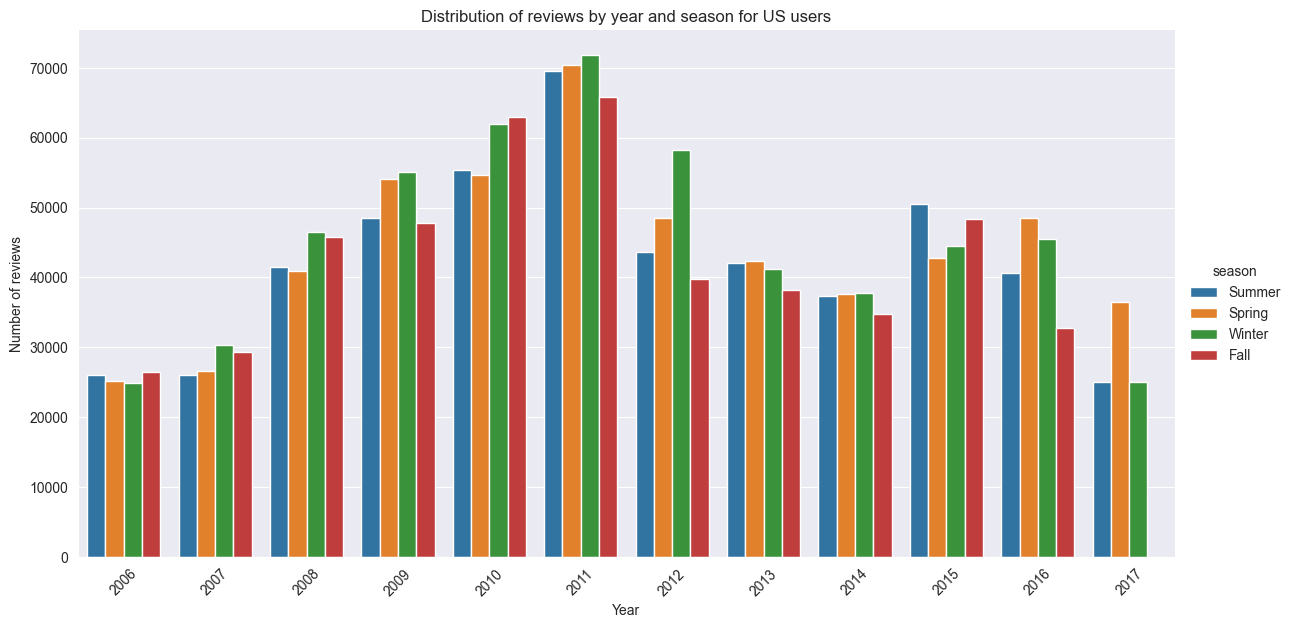

In [24]:
sns.catplot(data=reviews, x='year', hue='season', kind='count', height=6, aspect=2, legend=True)
plt.title('Distribution of reviews by year and season for US users')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

Between 2006 and 2017, there is no distinct season with consistently higher review activity, except for notable peaks in Winter 2012 and Spring 2017.

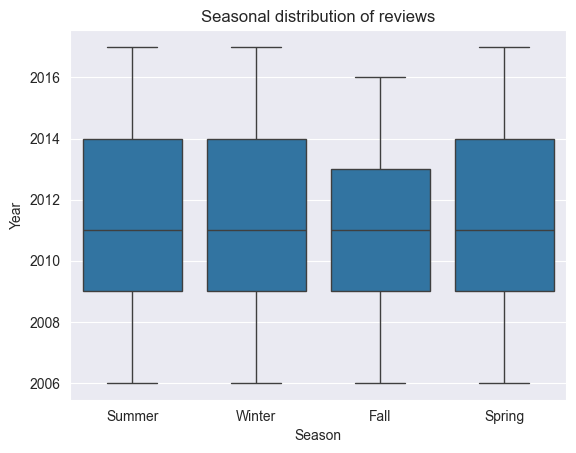

In [25]:
sns.boxplot(x='season', y='year', data=reviews)
plt.title('Seasonal distribution of reviews')
plt.xlabel('Season')
plt.ylabel('Year')
plt.show()

Each season has approximately the same number of reviews.

## Seasonal trend analysis

To understand the seasonal analysis, it is important to understand how the beers are rated. In both reviews and ratings dataframes, 6 columns contain metrics ( which are a score out of 5): appearance, aroma, taste, mouthfeel, overall and rating. The rating metrics is computed based on the 5 other scores with the following formula:
$$
\text{rating} = 0.06 \cdot \text{appearance} + 0.24 \cdot \text{aroma} + 0.4 \cdot \text{taste} + 0.1 \cdot \text{mouthfeel} + 0.2 \cdot \text{overall}
$$


In [26]:
from src.scripts.script import anova_test

In [27]:
print("Number of NaN values in ratings:", ratings['rating'].isnull().sum())

Number of NaN values in ratings: 444092


In [17]:
ratings = ratings.dropna(subset=['rating'])

In [18]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']

season_order = ['Winter', 'Spring', 'Summer', 'Fall']
ratings['season'] = pd.Categorical(ratings['season'], categories=season_order, ordered=True)

### For all years

In this section, we analyze the impact of style and alcohol concentration on the rating of a beer across seasons. This analysis is performed with the ratings from all years selected in the previous section.

#### By simplified styles

In this subsection, we analyze the impact of the style of the beer on its rating across seasons.

In [23]:
ratings_top_styles = ratings[ratings['style_simp'].isin(beer_styles_above_2_percent)]
reviews_top_styles = reviews[reviews['style_simp'].isin(beer_styles_above_2_percent)]

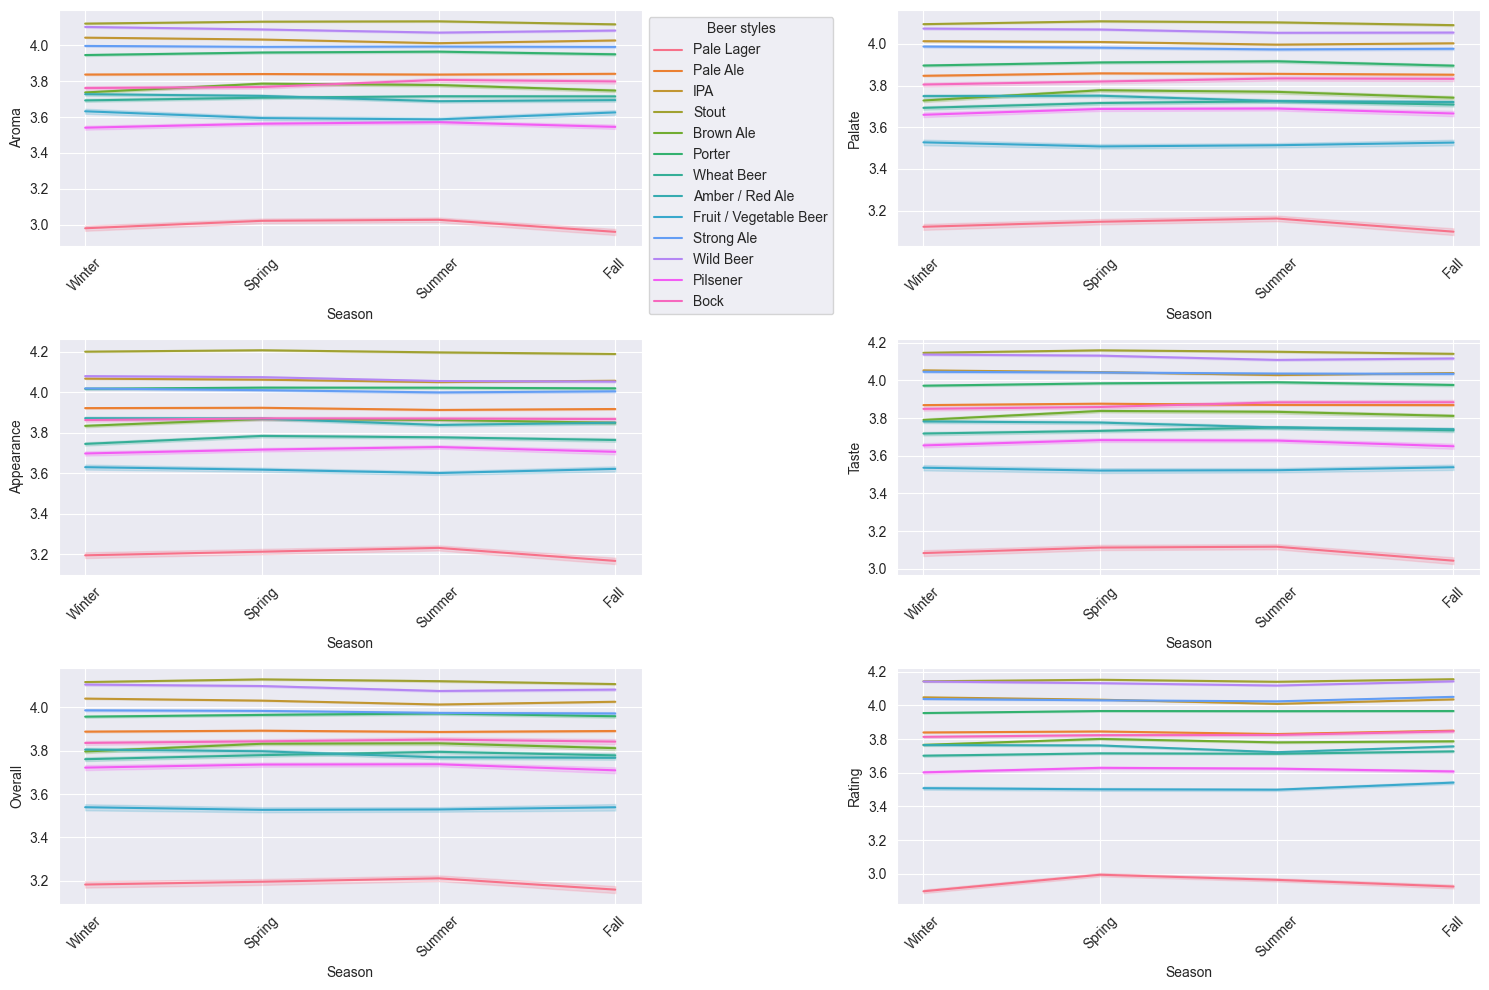

In [31]:
plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings_top_styles, x='season', y=rating, hue='style_simp', markers=True, dashes=False)

    plt.xlabel('Season')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Beer styles', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

From the plots above, we can observe that the beers belonging to the **Pale Lager** style show visible variation beetween seasons, especially between winter and spring. For the other styles, the variability is not visible if it exists, especially in the rating score, which contains all other metrics.

In [32]:
anova_season_rating_style = anova_test(ratings_top_styles, rating_column='rating', timescale='season', category='style_simp') 

style_simp: Pale Lager, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring   0.0701    0.0  0.0502    0.09   True
  Fall Summer   0.0399    0.0  0.0207  0.0591   True
  Fall Winter   -0.028 0.0019  -0.048  -0.008   True
Spring Summer  -0.0302 0.0001 -0.0487 -0.0118   True
Spring Winter  -0.0981    0.0 -0.1174 -0.0788   True
Summer Winter  -0.0679    0.0 -0.0864 -0.0493   True
----------------------------------------------------
--------------------------------------------------
style_simp: Pale Ale, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring  -0.0048 0.0489 -0.0095    -0.0 

The variability visibly seen in the graph for the **Pale Lager** style, is also seen in the ANOVA statistical test. Particularly, there is almost a 0.1 difference in between the ratings in spring and winter; the beer style is rated lower in winter than in spring. 

The **Bitter** style shows no difference in ratings amongst pairs with the Tukey HSD, the group anova p_value was 0.04 so the difference in between the groups was not significant.

For other all other beer styles, at least one difference in between season is observed. A few beer styles are consistently rated higher in fall than in winter: **Pale Ale** (~0.02 difference), **IPA** (~0.03) and **Stout** (~0.02).

We can also observe some paterns in terms of rating for some beer styles:
* **Brown Ale**: In spring, the beer is rated higher than in winter (~0.04); fall and summer ratings are similar 
* **Porter**: Winter ratings are lower than the ones in all other seasons (~0.01)
* **Amber/Red Ale**: Summer ratings are higher than in all other seasons (~0.04)
* **Pilsener**: Fall and winter have similar ratings, same phenomenon for spring and summer; spring and summer ratings are higher than in fall and winter

#### By alcohol concentration

In this subsection, we analyze the impact of the concentration of alcohol on a beer rating across seasons. 

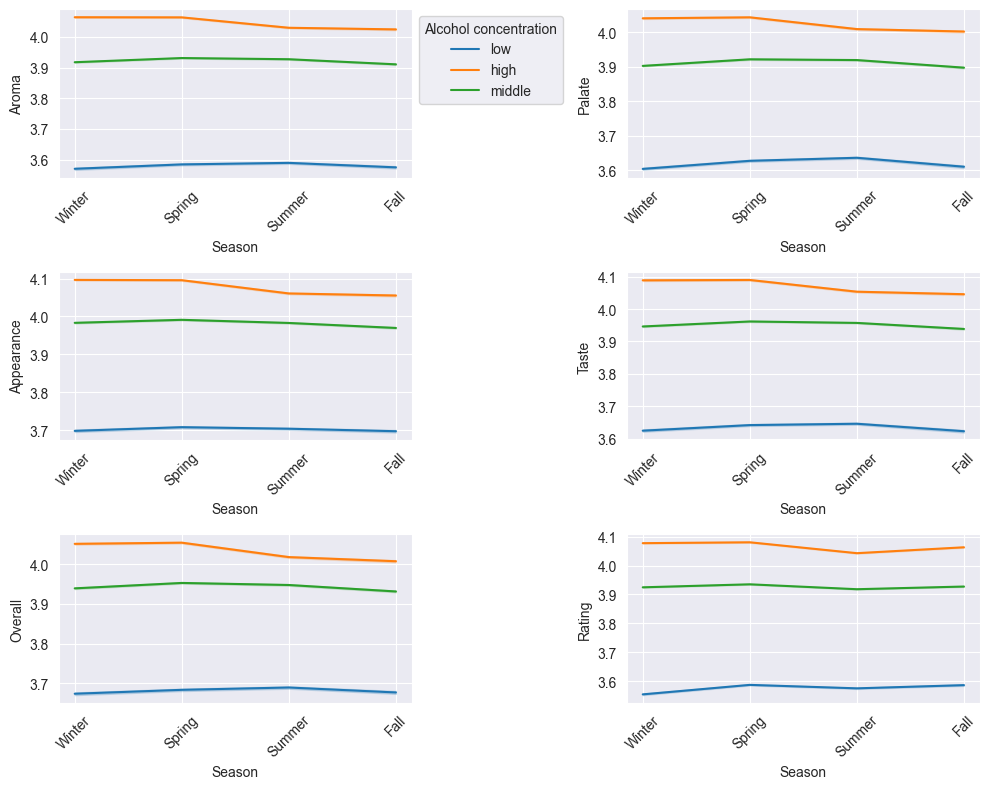

In [33]:
plt.figure(figsize=(10, 8))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings, x='season', y=rating, hue='abv_category', markers=True, dashes=False)

    plt.xlabel('Season')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Alcohol concentration', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

All metrics follow the same trend across seasons for each alcohol concentration category. Very few variation is observed in between seasons visually. Winter ratings seem to be lower than for other seasons for beers with low alcohol concentration. The opposite can be observed for beers with higher alcohol concentration, they are rated higher in winter than in summer.

In [34]:
anova_season_rating_abv = anova_test(ratings, rating_column='rating', timescale='season', category='abv_category') 

abv_category: low, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  Fall Spring   0.0009 0.959 -0.0037  0.0054  False
  Fall Summer  -0.0111   0.0 -0.0154 -0.0067   True
  Fall Winter   -0.032   0.0 -0.0366 -0.0273   True
Spring Summer   -0.012   0.0 -0.0163 -0.0077   True
Spring Winter  -0.0328   0.0 -0.0374 -0.0283   True
Summer Winter  -0.0209   0.0 -0.0253 -0.0165   True
---------------------------------------------------
--------------------------------------------------
abv_category: high, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring   0.0173    0.0  0.0144  0.0201   True
  Fall Sum

There is a significant difference between ratings for all alcohol concentration in between all seasons; except for the low alcohol concentration beers, in between fall and spring ratings. 

The difference depend on the alcohol concentration category. For example, lower and mid alcohol concentration are rated higher in summer than in winter; it is the opposite way for higher alcohol concentration beers. 

Especially, the higher difference in ratings in between seasons for each alcohol concentration category:
* **low**: The beers are rated higher in spring than in winter (~0.03 difference)
* **mid**: The beers are also rated higher in spring than in winter, but the difference is smaller (~0.01)
* **high**: The beers are rated the lowest during summer compared to fall and winter (~0.04)

### Year by year

##### By simplified style

In this section, we analyze the evolution of ratings for different beer styles across years.

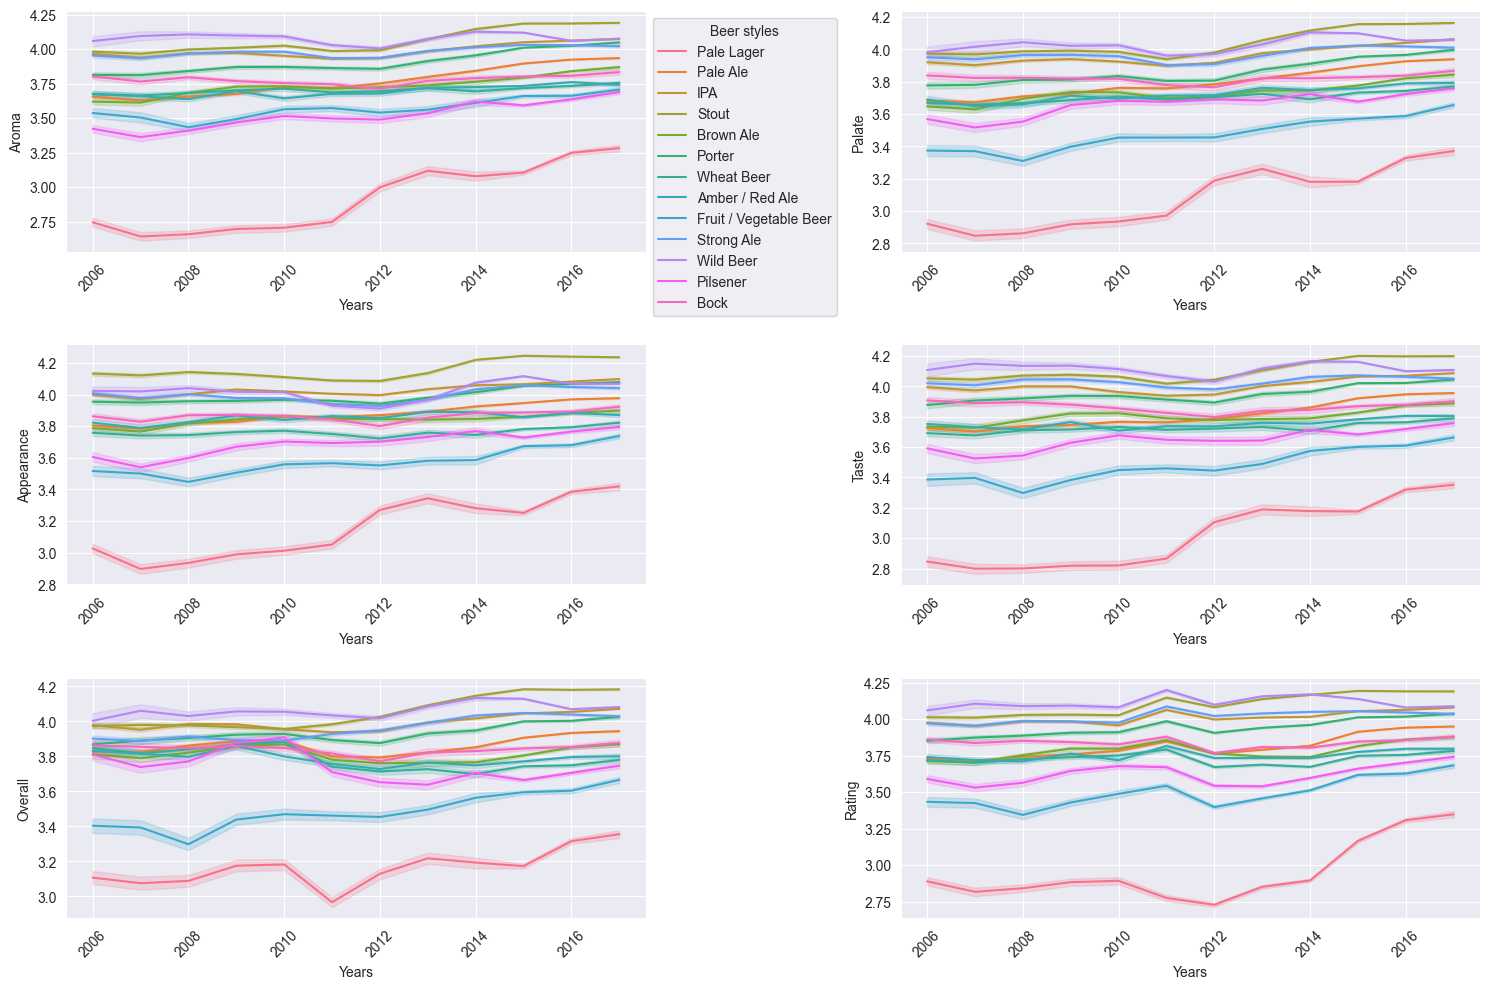

In [35]:
plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings_top_styles, x='year', y=rating, hue='style_simp', markers=True, dashes=False)

    plt.xlabel('Years')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Beer styles', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

We can observe from the plots that there has been a clear increase in ratings for the **Pale Lager** beers from around 2012 to 2017. For the other beer styles, there seem to have been a general increase from 2006 to 2017 but it is harder to evaluate. Moreover, it seems that around 2010 to 2012, there has been a decrease in ratings for almost all beer types, followed then by an increase until 2017.

In [36]:
anova_year_rating_style = anova_test(ratings_top_styles, rating_column='rating', timescale='year', category='style_simp') 

style_simp: Pale Lager, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between year
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
2006.0 2007.0  -0.0718 0.0935 -0.1487   0.005  False
2006.0 2008.0  -0.0475 0.5778 -0.1194  0.0243  False
2006.0 2009.0   -0.006    1.0 -0.0787  0.0666  False
2006.0 2010.0   0.0034    1.0 -0.0679  0.0748  False
2006.0 2011.0  -0.1139    0.0 -0.1778   -0.05   True
2006.0 2012.0  -0.1611    0.0 -0.2202 -0.1021   True
2006.0 2013.0   -0.038 0.5992 -0.0962  0.0202  False
2006.0 2014.0    0.006    1.0 -0.0513  0.0632  False
2006.0 2015.0   0.2765    0.0  0.2172  0.3358   True
2006.0 2016.0   0.4186    0.0  0.3577  0.4794   True
2006.0 2017.0   0.4588    0.0  0.3911  0.5265   True
2007.0 2008.0   0.0243 0.9944 -0.0475  0.0961  False
2007.0 2009.0   0.0658 0.1192 -0.0068  0.1384  False
2007.0 2010.0   0.0753 0.0279   0.004  0.1466 

The ANOVA and Tukey HSD taking a lot of space, the important values from those tests are described below. This is not an extensive description but an idea of a validation for the general trend seen on the graph.

From 2006 to 2017, the **Pale Lager** style has indeed increase its rating by 0.46 points; the most significant increase is as seen on the graph between 2012 and 2017, it has increased by 0.62 points. The ratings were stable from 2006 to 2010, it decreased then by 0.16 until 2012 before the increase. 

Other styles such as **Pale Ale** followed the same trend but with less differences; the ratings were stable from 2006 to 2008, an initial increase from 2008 to 2011 of 0.1 points followed by a decrease of 0.08 points in 2012 and then an increase of 0.18 points from 2012 to 2017.

The **Bitter** style shows almost no significant variation in ratings throughout the years. Small fluctuations of about 0.1 points occur, for example the same decrease in between 2011 and 2012 is observed (~0.1) followed by an increase of 0.1 until 2017.

#### By alcohol concentration

In this section, we analyze the impact of the concentration of alcohol on the rating of a beer across years. 

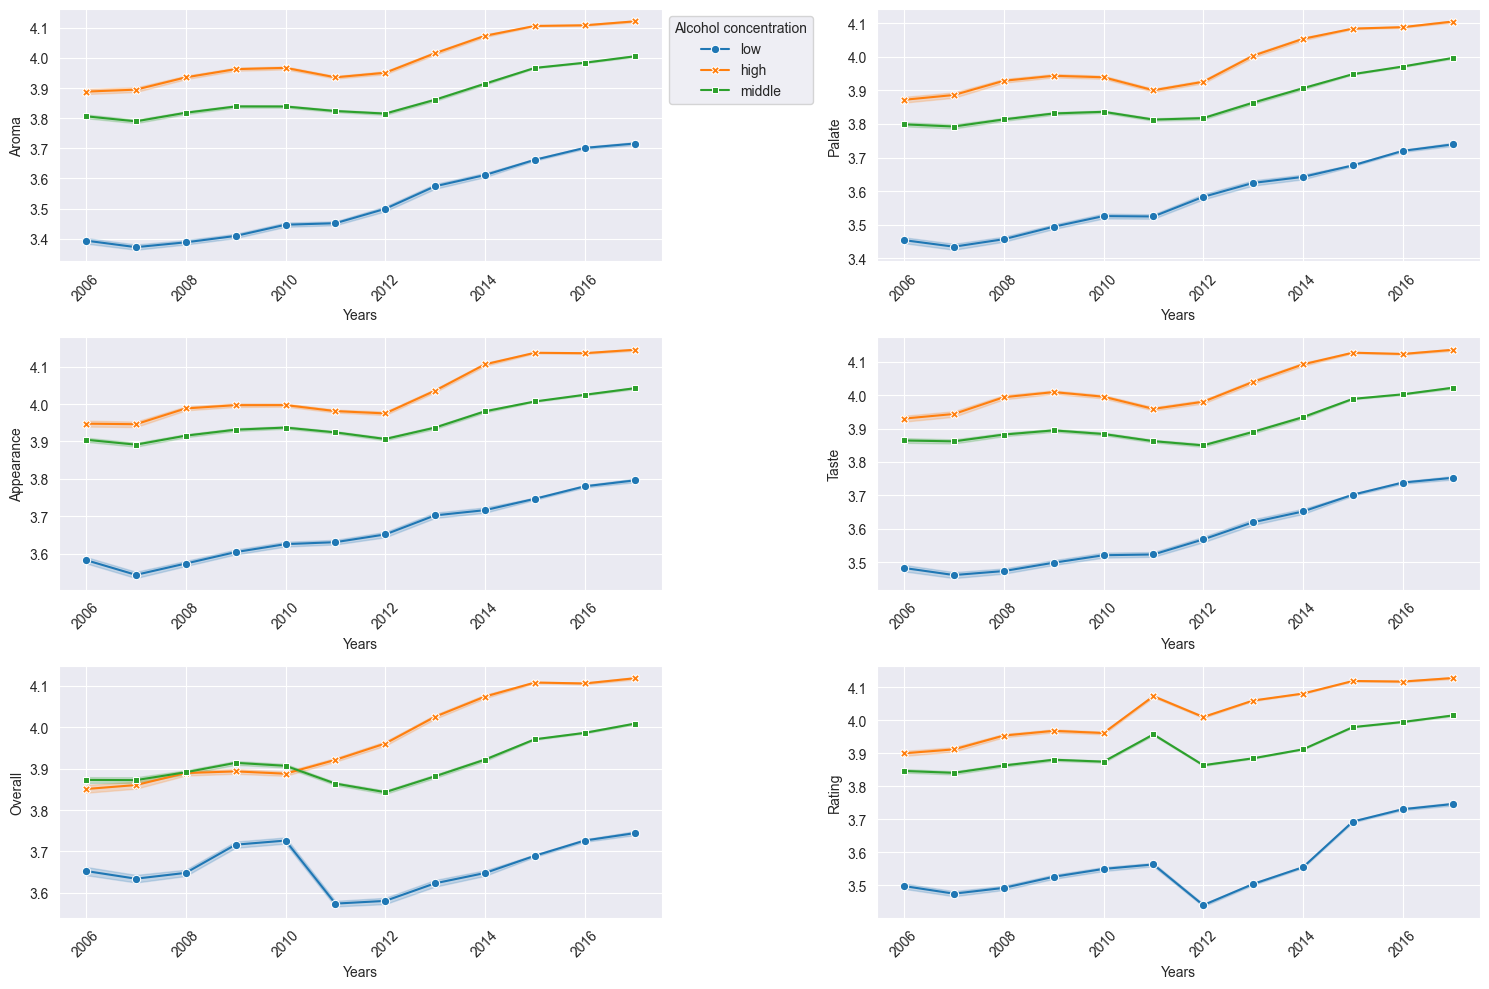

In [37]:
plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings, x='year', y=rating, hue='abv_category', style='abv_category', markers=True, dashes=False)

    plt.xlabel('Years')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Alcohol concentration', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

Across years, all metric have the same evolution trend for all alcohol concentrations, except for the overall score which shows more variability. We observe the same general trend as when the beers were separated by style; a slight increase from 2006 to 2011, a decrease between 2011 and 2012, followed by an increase until 2017. 

Besides, we can also observe that the higher the alcohol content, the more a beer is liked. The lower concentration in alcohol consistently obtain lower scores. 

### By states

In this section, we analyze whether the users’ regions of origin influence their ratings across different seasons. The four regions (South, Midwest, Northeast, and West) experience different climate conditions. For example, winters in the Northeast are typically much colder than those in the South. These seasonal climate differences may shape user preferences and, consequently, their ratings. By examining these patterns, we aim to understand if and how seasonal variations across regions impact user ratings.

#### Comparaison by states

First, we need to ensure that the number of ratings is relatively consistent across each category:

/var/folders/9b/th5400l94kqcyysbyv63p_bm0000gn/T/ipykernel_9741/3342782107.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ratings_count = ratings.groupby(['region', 'season'])['overall'].count().reset_index()
/var/folders/9b/th5400l94kqcyysbyv63p_bm0000gn/T/ipykernel_9741/3342782107.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = ratings_count.pivot_table(


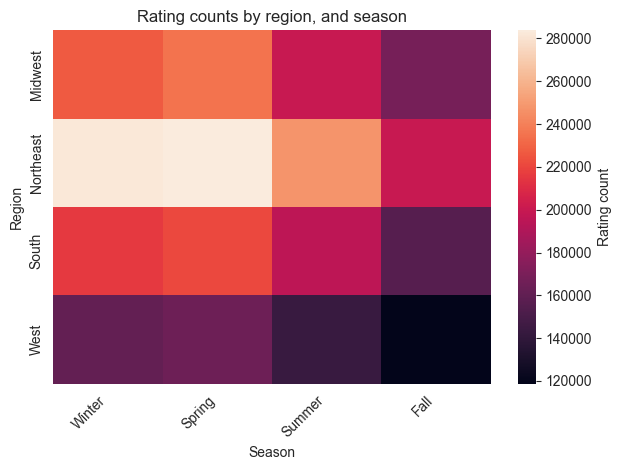

In [38]:
ratings_count = ratings.groupby(['region', 'season'])['overall'].count().reset_index()
ratings_count = ratings_count.rename(columns={'overall': 'rating_count'})

pivot_table = ratings_count.pivot_table(
    index='region', columns='season', values='rating_count', fill_value=0
)

sns.heatmap(pivot_table, cbar_kws={'label': 'Rating count'})
plt.title("Rating counts by region, and season")
plt.xlabel("Season")
plt.ylabel("Region")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There are more ratings from users in the Northeast, which is expected given that states like New York and Pennsylvania are more prominently represented among the users.

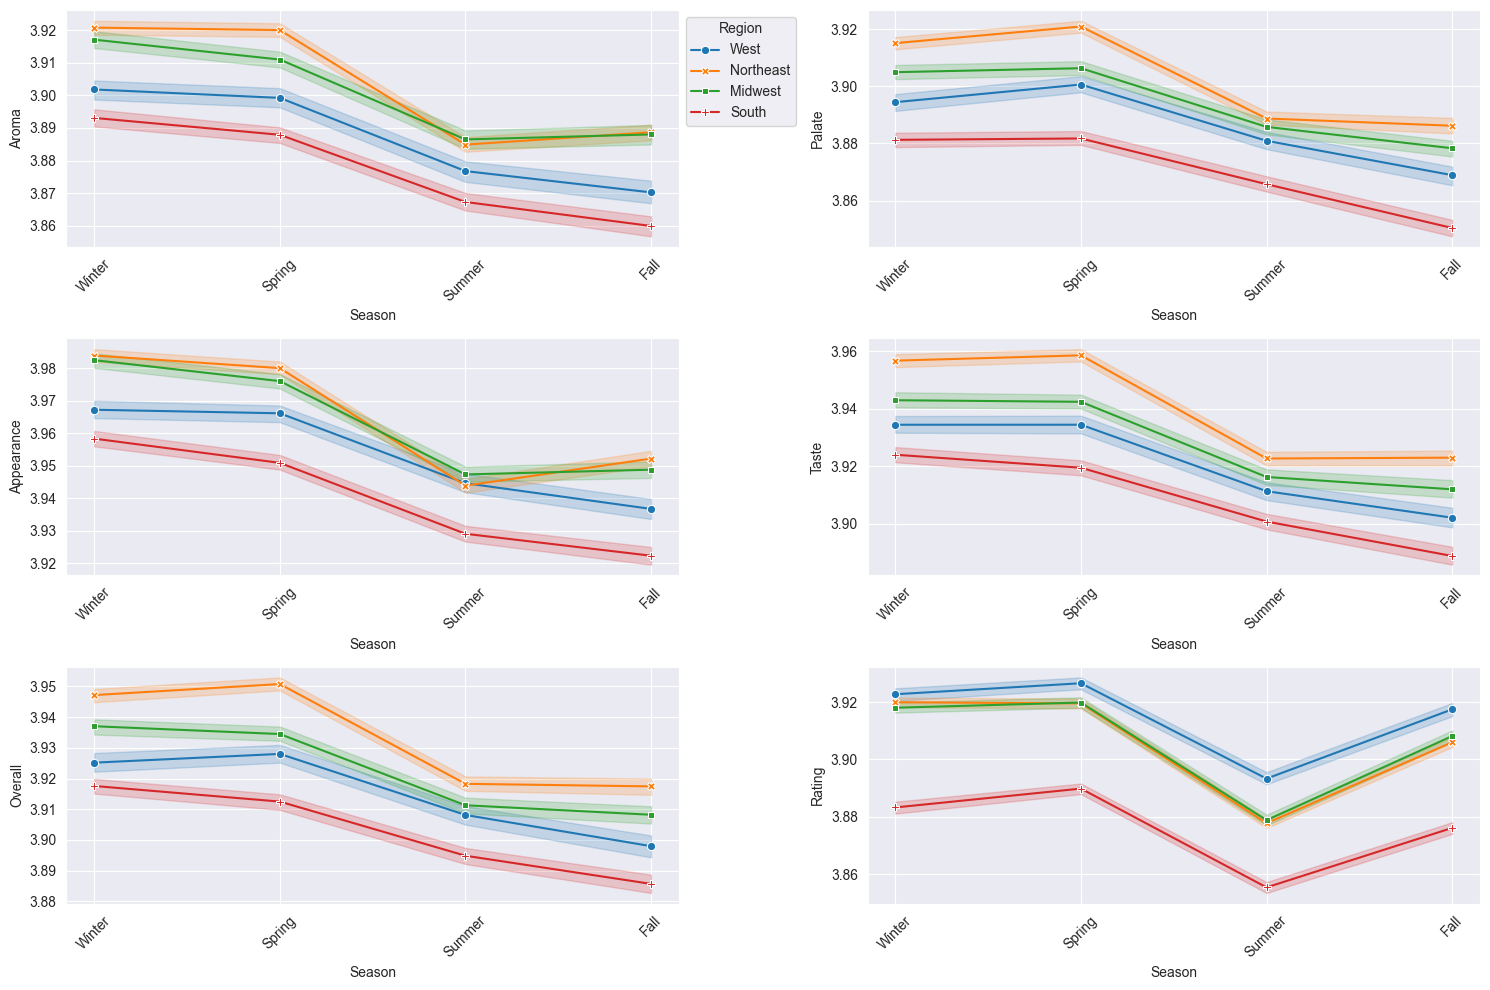

In [39]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']


plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=ratings, x='season', y=rating, hue='region', style='region', markers=True, dashes=False)

    plt.xlabel('Season')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    if plt_index == 1:
        plt.legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

We observe a similar trend across all rating categories (aroma, palate, taste, appearance, overall, and rating). Therefore, we can continue the analysis by focusing on the ‘rating’ variable, which serves as a composite score derived from the other five ratings.

South users give the lowest ratings across all season.

In [40]:
from src.scripts.script import seasonal_region_test

In [41]:
anova_results= seasonal_region_test(ratings, rating_column='rating') 

Season: Summer, Rating Column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast  -0.0011 0.8359 -0.0044  0.0022  False
  Midwest     South  -0.0234    0.0 -0.0269   -0.02   True
  Midwest      West   0.0145    0.0  0.0107  0.0182   True
Northeast     South  -0.0224    0.0 -0.0257 -0.0191   True
Northeast      West   0.0156    0.0  0.0119  0.0192   True
    South      West   0.0379    0.0  0.0342  0.0417   True
----------------------------------------------------------
--------------------------------------------------
Season: Winter, Rating Column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------

In all seasons, the South region consistently shows significant differences when compared to the other regions, with the West and Midwest regions also exhibiting notable differences.

#### Comparaison by states and alcohol content

First, we need to ensure that the number of ratings is relatively consistent across each category:

/var/folders/9b/th5400l94kqcyysbyv63p_bm0000gn/T/ipykernel_9741/3507937438.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ratings_count = ratings.groupby(['abv_category', 'region', 'season'])['overall'].count().reset_index()
/var/folders/9b/th5400l94kqcyysbyv63p_bm0000gn/T/ipykernel_9741/3507937438.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = ratings_count.pivot_table(


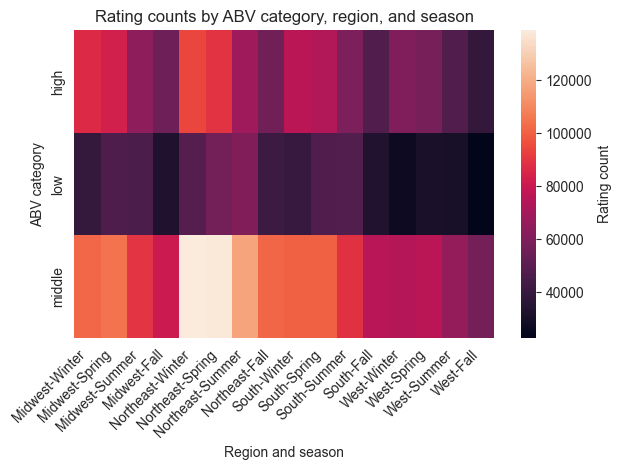

In [42]:
ratings_count = ratings.groupby(['abv_category', 'region', 'season'])['overall'].count().reset_index()
ratings_count = ratings_count.rename(columns={'overall': 'rating_count'})

pivot_table = ratings_count.pivot_table(
    index='abv_category', columns=['region', 'season'], values='rating_count', fill_value=0
)

sns.heatmap(pivot_table, cbar_kws={'label': 'Rating count'})
plt.title("Rating counts by ABV category, region, and season")
plt.xlabel("Region and season")
plt.ylabel("ABV category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The middle abv category has the highest rating count, this is expected as we used 25-50% quantile and the other abv category only 25% of the total number of ratings. There are however more ratings for the Northeast users during winter.  

/var/folders/9b/th5400l94kqcyysbyv63p_bm0000gn/T/ipykernel_9741/637054815.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_ratings = ratings.groupby(['season', 'region', 'abv_category'])[rating_columns].mean().reset_index()


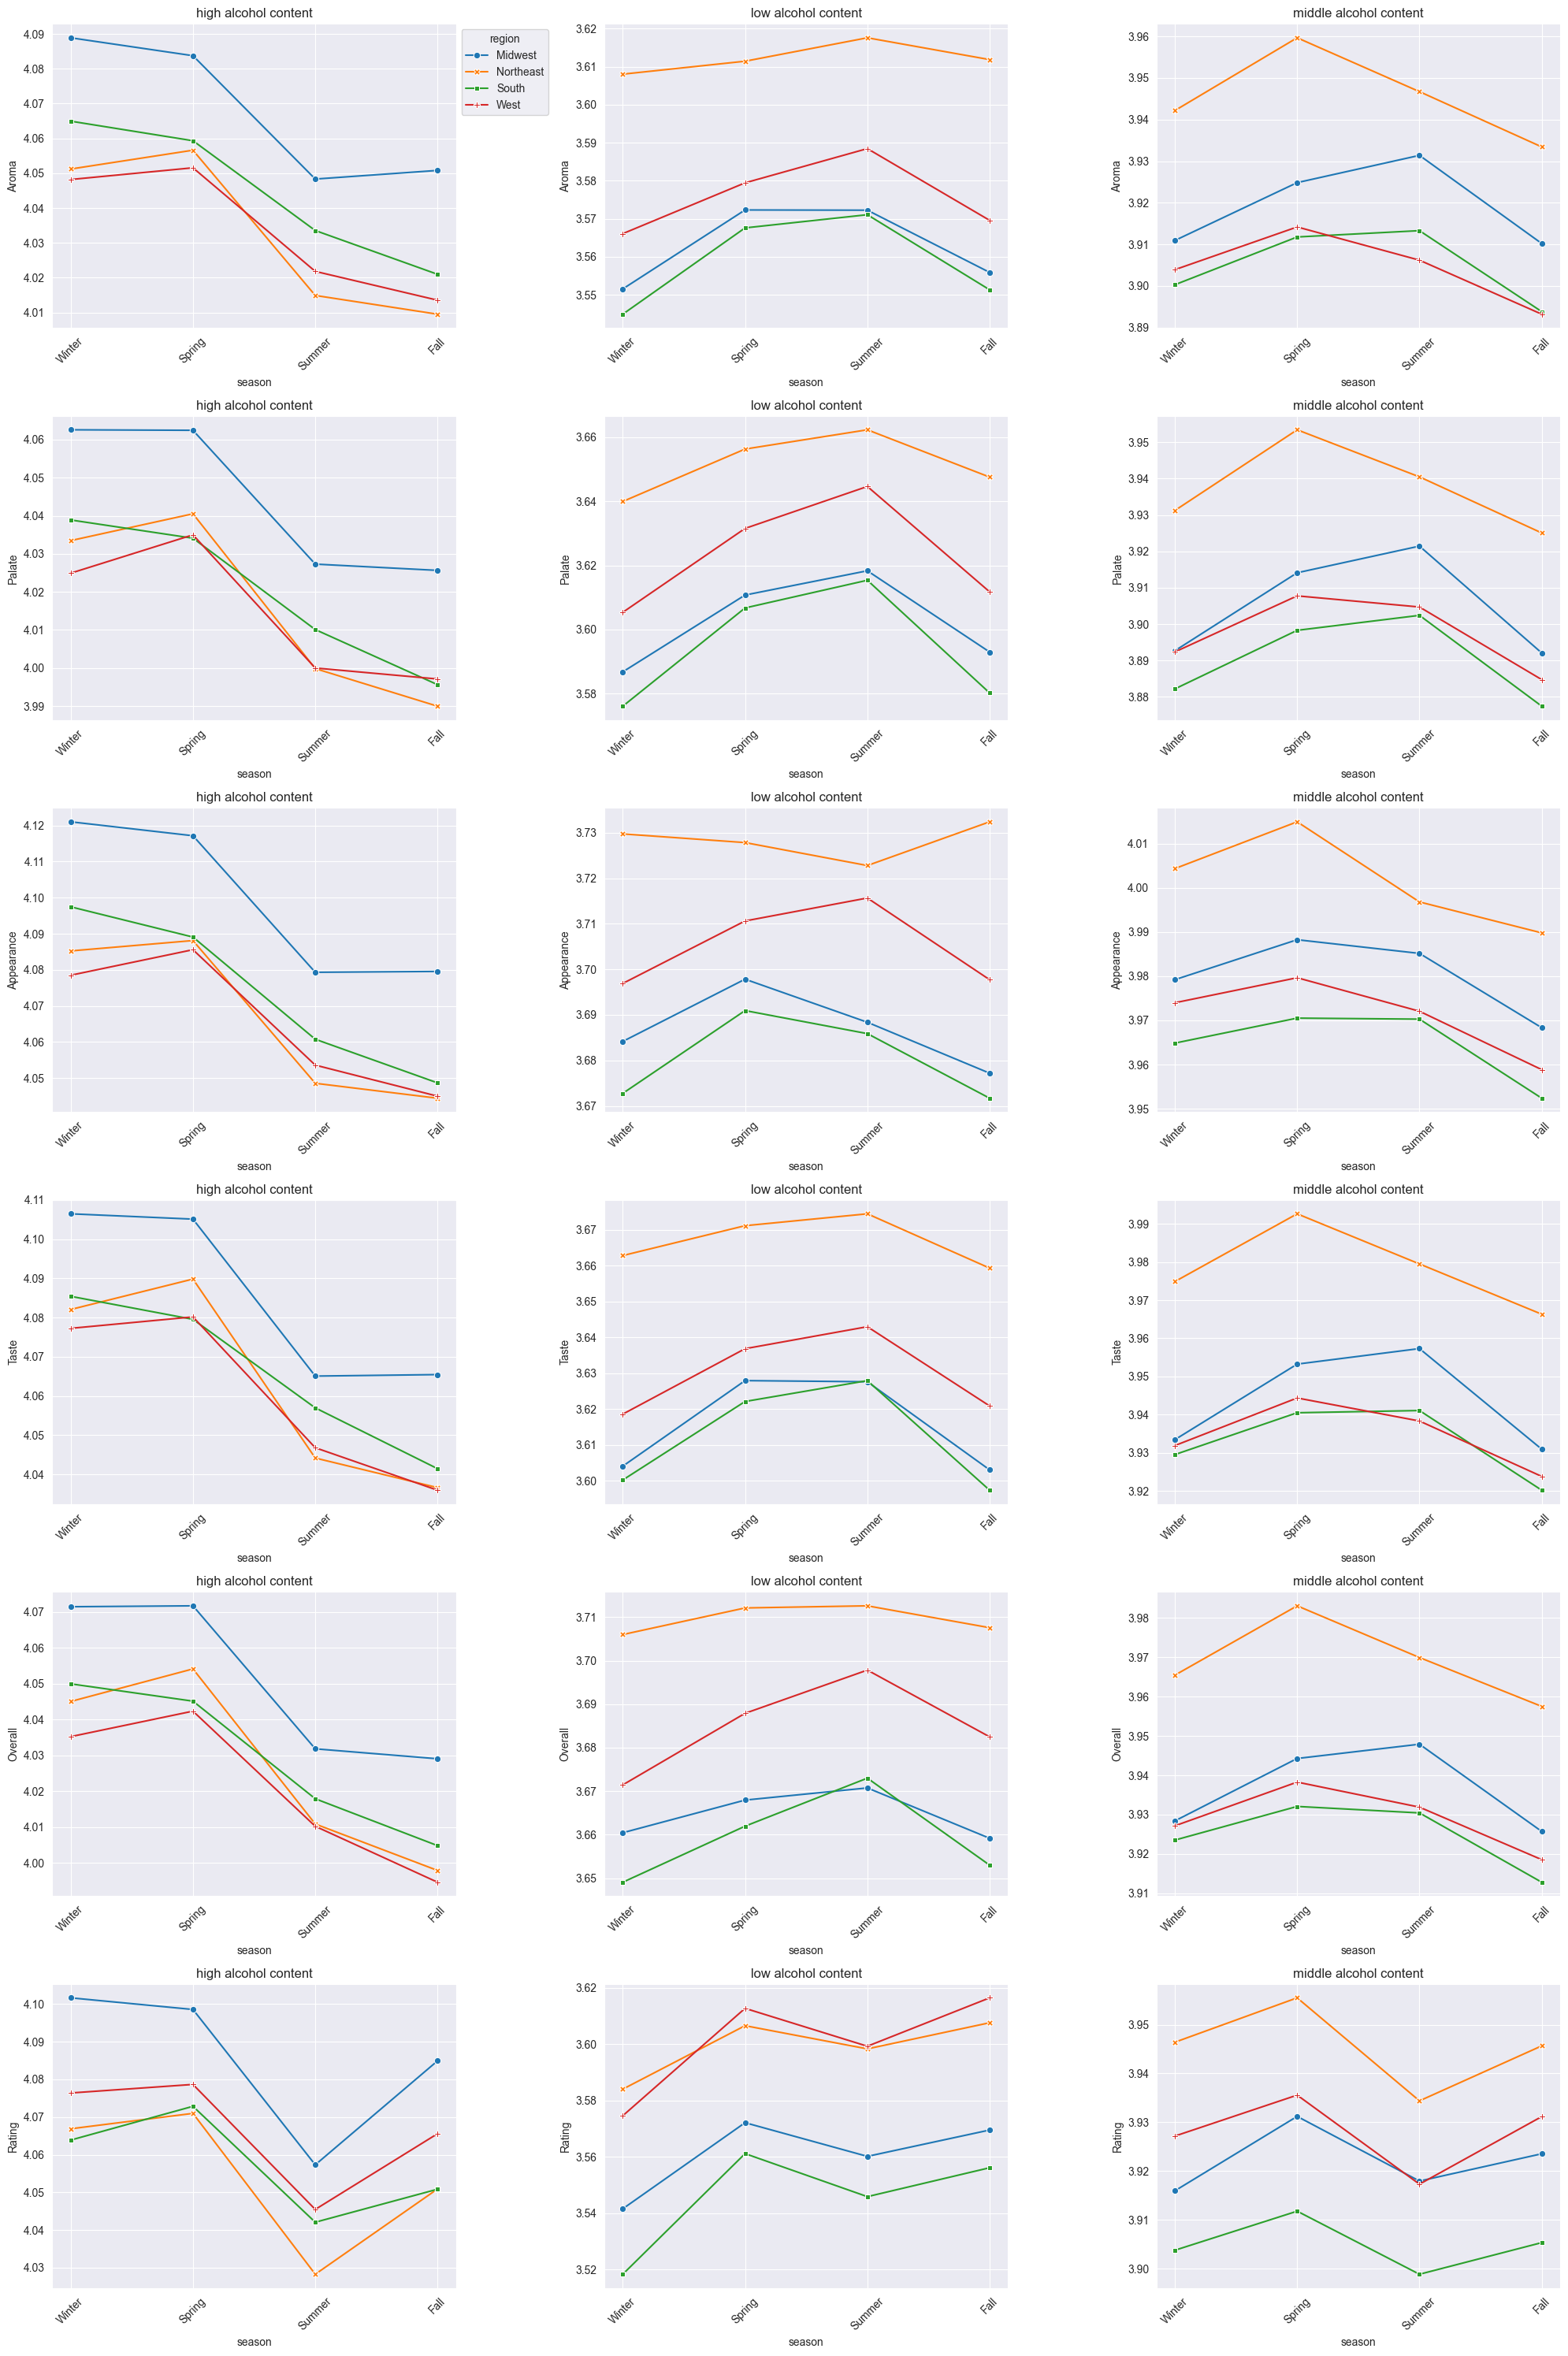

In [43]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']
grouped_ratings = ratings.groupby(['season', 'region', 'abv_category'])[rating_columns].mean().reset_index()

# All ABV categories
abvs = grouped_ratings['abv_category'].unique()

plt.figure(figsize=(20, 30))


for j, rating in enumerate(rating_columns):
    for i, abv in enumerate(abvs):
        
        # Calculate the plot index for the grid
        plt_index = j * len(abvs) + i + 1
        plt.subplot(6, 3, plt_index)
        
        # Filter data for the ABV category
        abv_data = grouped_ratings[grouped_ratings['abv_category'] == abv]
        
        sns.lineplot(data=abv_data, x='season', y=rating, hue='region', style='region', markers=True, dashes=False)
        
        plt.title(f'{abv} alcohol content')
        plt.xlabel('season')
        plt.ylabel(f'{rating.capitalize()}')
        plt.xticks(rotation=45)
        
        if plt_index == 1:
            plt.legend(title='region', loc='upper left', bbox_to_anchor=(1, 1))
        else:
            plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

We observe a similar trend across all rating categories (aroma, palate, taste, appearance, overall, and rating). Therefore, we can continue the analysis by focusing on the ‘rating’ variable, which serves as a composite score derived from the other five ratings.

**statistical analysis:**

In [44]:
from src.scripts.script import seasonal_region_abv_test

In [45]:
anova_results_low = seasonal_region_abv_test(ratings, abv_category='low', rating_column='rating')

season: Summer, ABV category: low, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast   0.0382    0.0  0.0306  0.0457   True
  Midwest     South  -0.0143    0.0 -0.0222 -0.0064   True
  Midwest      West   0.0391    0.0  0.0301  0.0481   True
Northeast     South  -0.0525    0.0 -0.0599  -0.045   True
Northeast      West   0.0009 0.9924 -0.0077  0.0096  False
    South      West   0.0534    0.0  0.0445  0.0623   True
----------------------------------------------------------
--------------------------------------------------
season: Winter, ABV category: low, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
-

In [46]:
anova_results_high = seasonal_region_abv_test(ratings, abv_category='high', rating_column='rating')

season: Summer, ABV category: high, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast  -0.0291    0.0 -0.0346 -0.0236   True
  Midwest     South  -0.0152    0.0 -0.0209 -0.0096   True
  Midwest      West  -0.0118    0.0 -0.0179 -0.0058   True
Northeast     South   0.0138    0.0  0.0082  0.0194   True
Northeast      West   0.0172    0.0  0.0113  0.0232   True
    South      West   0.0034 0.4794 -0.0027  0.0095  False
----------------------------------------------------------
--------------------------------------------------
season: Winter, ABV category: high, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject

In [47]:
anova_results_middle = seasonal_region_abv_test(ratings, abv_category='middle', rating_column='rating')

season: Summer, ABV category: middle, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast   0.0164    0.0  0.0121  0.0208   True
  Midwest     South  -0.0191    0.0 -0.0237 -0.0145   True
  Midwest      West  -0.0006 0.9876 -0.0056  0.0043  False
Northeast     South  -0.0355    0.0 -0.0399 -0.0312   True
Northeast      West  -0.0171    0.0 -0.0218 -0.0123   True
    South      West   0.0185    0.0  0.0135  0.0234   True
----------------------------------------------------------
--------------------------------------------------
season: Winter, ABV category: middle, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower   upper  reje

The ratings made by users in different regions (South, Midwest, Northeast, and West) are statistically significant.

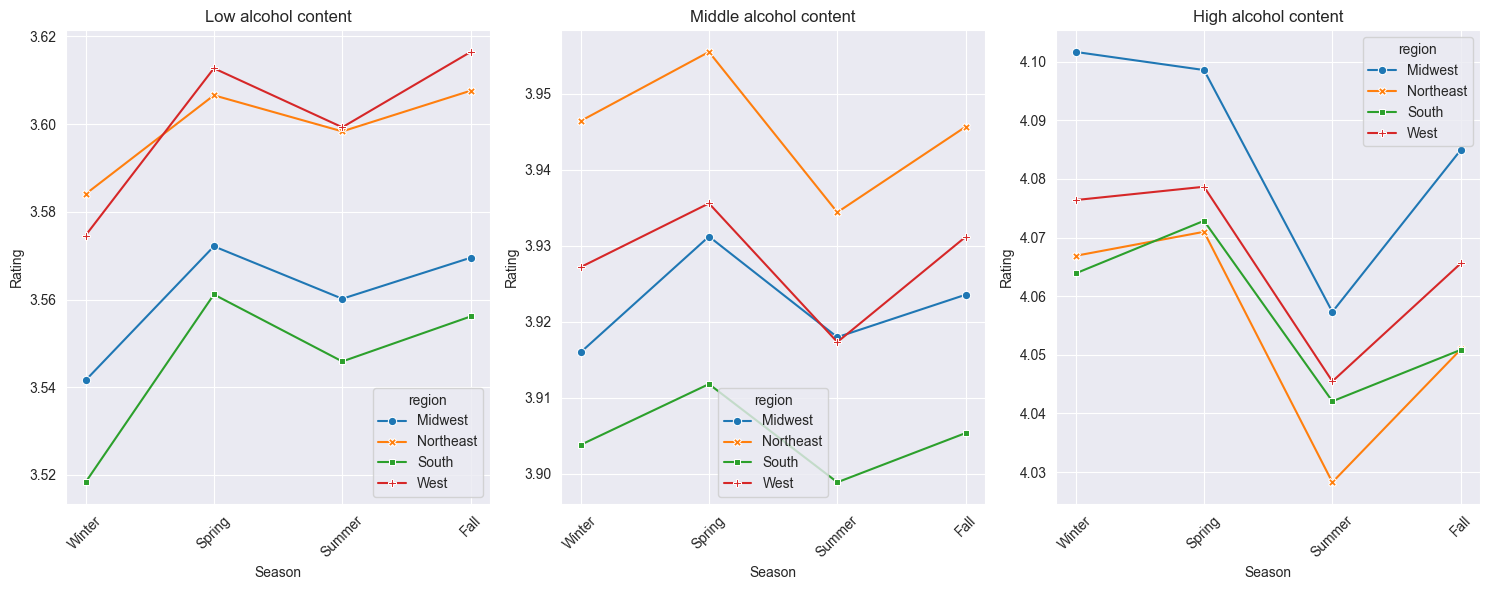

In [48]:
abvs = ['low', 'middle', 'high']  

plt.figure(figsize=(15, 6))  

for j, abv in enumerate(abvs):
    plt_index = j + 1 
    plt.subplot(1, 3, plt_index) 
    
    abv_data = grouped_ratings[grouped_ratings['abv_category'] == abv]
    
    sns.lineplot(data=abv_data, x='season', y='rating', hue='region', style='region', markers=True, dashes=False)
    
    plt.title(f'{abv.capitalize()} alcohol content')
    plt.xlabel('Season')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)

plt.tight_layout() 
plt.show()

 West users give higher ratings for low alcohol content in Spring and Fall than Northeast users but not in Winter. Across all seasons, Northeast users give higher ratings for middle alcohol content, Midwest users for higher alcohol content and Northest and West users for lower alcohol content. 

#### Comparaison by states and alcohol content

In [49]:
best_rated = ratings.groupby(['season', 'region', 'style_simp'])['rating'].mean().reset_index()

# Sort the values by rating in descending order
best_rated = best_rated.sort_values(by=['season', 'region', 'rating'], ascending=[True, True, False])

# Get top 3 beer styles for each region and season
top_3 = best_rated.groupby(['season', 'region']).head(1).reset_index(drop=True)

/var/folders/9b/th5400l94kqcyysbyv63p_bm0000gn/T/ipykernel_9741/1616549545.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_rated = ratings.groupby(['season', 'region', 'style_simp'])['rating'].mean().reset_index()
/var/folders/9b/th5400l94kqcyysbyv63p_bm0000gn/T/ipykernel_9741/1616549545.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_3 = best_rated.groupby(['season', 'region']).head(1).reset_index(drop=True)


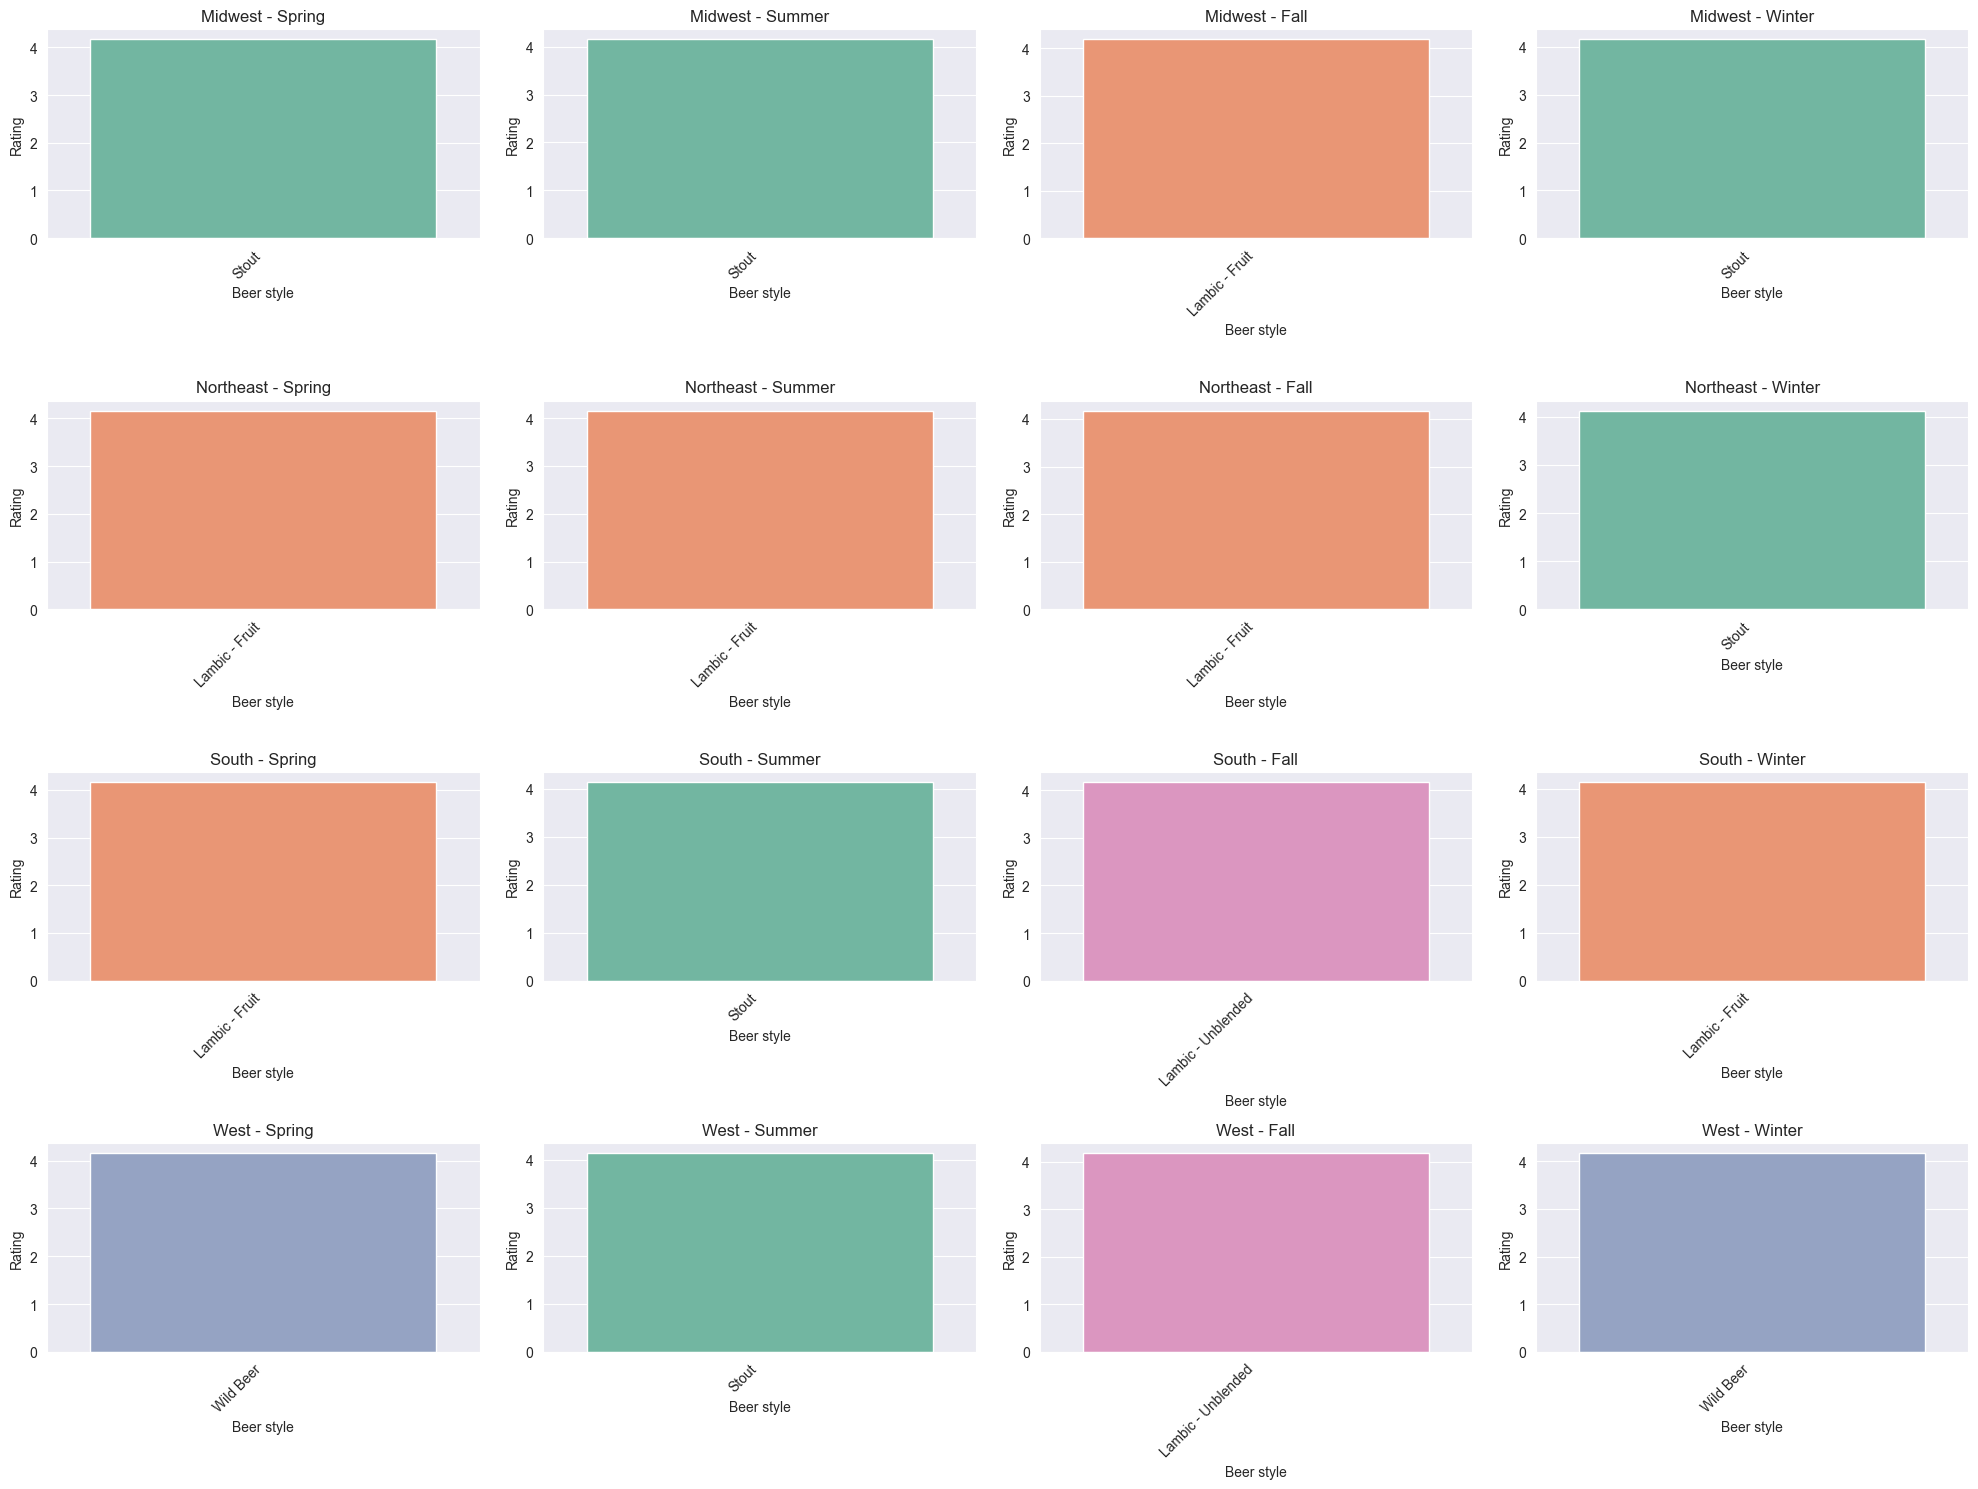

In [50]:
unique_styles = top_3['style_simp'].unique()
style_palette = sns.color_palette("Set2", n_colors=len(unique_styles))  
style_color_map = {style: style_palette[i] for i, style in enumerate(unique_styles)}

fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()

regions = top_3['region'].unique()
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

for i, region in enumerate(regions):
    for j, season in enumerate(seasons):
        ax = axes[i * 4 + j]
        
        data = top_3[(top_3['region'] == region) & (top_3['season'] == season)]
        
        palette = [style_color_map[style] for style in data['style_simp']]
        
        sns.barplot(x='style_simp', y='rating', data=data, ax=ax, hue='style_simp', palette=palette, legend=False)
        
        ax.set_title(f'{region} - {season}', fontsize=12)
        ax.set_xlabel('Beer style', fontsize=10)
        ax.set_ylabel('Rating', fontsize=10)
        ax.set_xticks(range(len(data['style_simp'])))
        ax.set_xticklabels(data['style_simp'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

The beer style the highest rated is not always the same across season and region. For example, in Summer, for all regions the highest beer style rated is Stout but not for the Northeast region that prefers Lambic Fruit in Summer. The West users tend to change each season the top1 rated beer while the Northeast users always have the Lambic Fruit highest ranked in Summer except in Winter.

## Sentiment analysis

In [72]:
def preprocess_text(text):
    words = re.findall(r'\b\w+\b', text.lower())  
    return words

In [ ]:
# Remove rows where 'text' is NaN or not a string
reviews_clean = reviews[reviews['text'].apply(lambda x: isinstance(x, str))]

# Now apply the preprocess_text function
reviews_clean['cleaned_tokens'] = reviews_clean['text'].apply(preprocess_text)

# Optionally, if you want to update the original reviews DataFrame, you can merge it back
reviews = reviews_clean

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eugeniecyrot/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [75]:
# Flatten the list of words from all reviews
all_words = [word for review_us in tqdm(reviews['cleaned_tokens'],desc="Processing") for word in review_us]
stop_words = set(stopwords.words('english'))
words = [word for word in tqdm(all_words, desc="Processing") if word.isalpha() and word not in stop_words and word.lower() != "beer"]

# Count word frequencies
word_freq = Counter(words)
top_20_words = word_freq.most_common(20)

# Print top 20 most common words
print(top_20_words)

Processing: 100%|██████████| 253627098/253627098 [00:55<00:00, 4577382.59it/s]


[('head', 1833519), ('taste', 1327911), ('light', 1307691), ('nice', 1286385), ('good', 1204004), ('like', 1198080), ('malt', 1132865), ('sweet', 1069814), ('hops', 1044442), ('one', 963752), ('carbonation', 954628), ('flavor', 939614), ('dark', 932450), ('bit', 930780), ('aroma', 830425), ('well', 826490), ('little', 802807), ('medium', 801121), ('finish', 767921), ('color', 756307)]


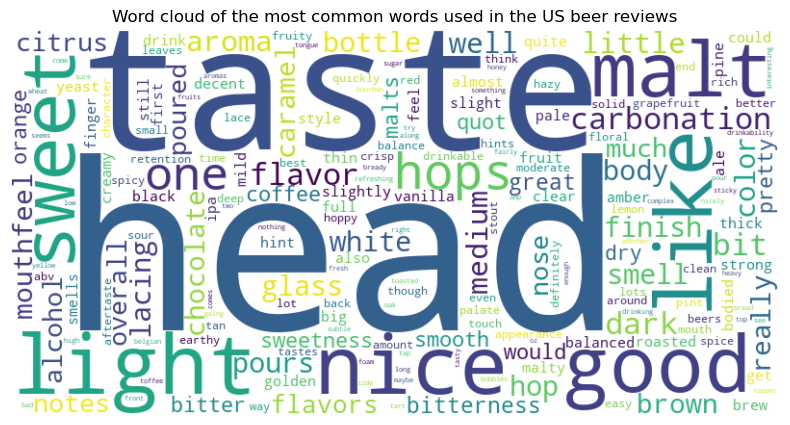

In [76]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color= 'white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common words used in the US beer reviews')
plt.show()

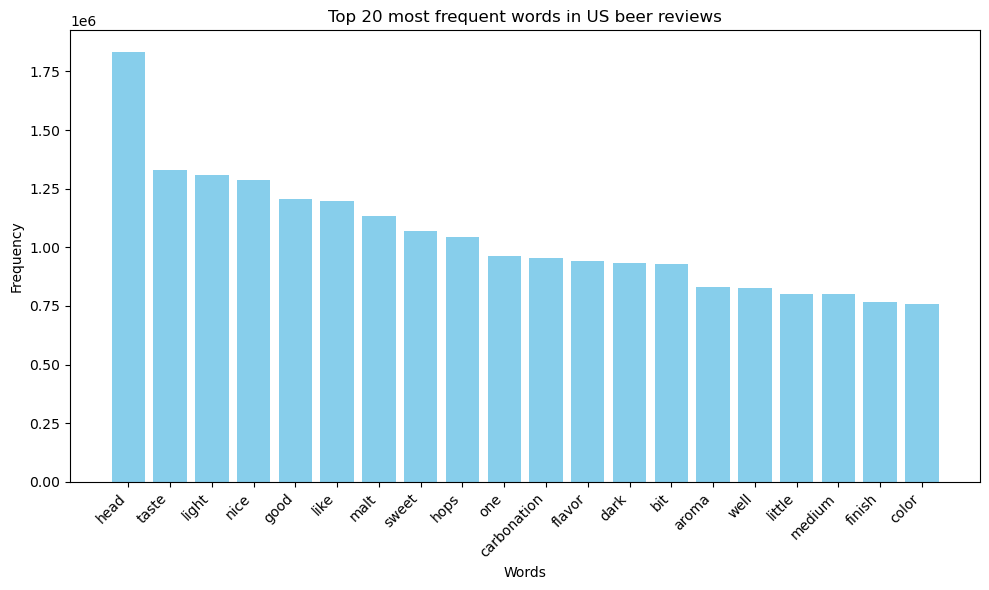

In [77]:
words, counts = zip(*top_20_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 most frequent words in US beer reviews')
plt.tight_layout()
plt.show()

From the most common words list we obtained, we can conclude we have a lot of words that are directly related to **beer terminology**, like "beer", "head", "tast"e, "flavor", "malt", "carbonation", etc., indicating that reviewers frequently discuss the sensory attributes of the beer. 

We also have a lot of **descriptive terms**, like "dark", "sweet", "nice", "bit", "medium", which will tell us how people perceive the beer. In further analysis, we will be able to able to match these terms with preference for specific beer types. For example, the use of term "sweet" could suggest a preference for sweeter beers, or those with a higher malt content.

Finally, a good proportion among the 20 most common words describe a **positive sentiment**, like "nice", "good", "well", "like", etc. As those words are obviously among the most frequently used ones, we can deduce people have a tendancy to rate beers when they have a positive feeling towards them. This will definitely help us finding the beers that receive the most positive reviews.



To conclude, this is quite satisfactory as we can see the data we obtained will be useful to do further analysis on beer preferences.

In [78]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [79]:
# Function to compute sentiment
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)['compound']
    return sentiment

# Function to classify words based on sentiment
def classify_words(word):
    sentiment_score = analyzer.polarity_scores(word)['compound']
    if sentiment_score > 0:
        return word, 'positive'
    elif sentiment_score < 0:
        return word, 'negative'
    return None  # Neutral words are ignored

# Analyze sentiment in parallel
def process_sentiments(top_words):
    print("Classifying words...")
    positive_words = []
    negative_words = []

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(classify_words, top_words), total=len(top_words), desc="Word Classification Progress"))
        
    # Filter out None values for neutral words and separate positive and negative words
    for result in results:
        if result:  # Skip None results
            word, sentiment = result
            if sentiment == 'positive':
                positive_words.append(word)
            elif sentiment == 'negative':
                negative_words.append(word)
    
    print("Word classification completed.")
    return positive_words, negative_words

In [80]:
# Get the 5000 most common words
top_5000_words = [word for word, count in word_freq.most_common(5000)]

# Process sentiment classification for the top 50000 words
positive_words, negative_words = process_sentiments(top_5000_words)

# Count the number of positive and negative words among these 50000 most common words
num_positive_words = len(set(top_5000_words).intersection(set(positive_words)))
num_negative_words = len(set(top_5000_words).intersection(set(negative_words)))

print(f"Number of positive words among the top 5000 words: {num_positive_words}")
print(f"Number of negative words among the top 5000 words: {num_negative_words}")


Classifying words...


Word Classification Progress: 100%|██████████| 5000/5000 [00:00<00:00, 305115.74it/s]

Word classification completed.
Number of positive words among the top 5000 words: 419
Number of negative words among the top 5000 words: 256


In [81]:
# Count word frequencies for positive and negative words
positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)

We observe there are nearly **twice more positive words than negative words**. This is totally relevent, as we can see on the BeerAdvocate website that users are asked to "be constructive with criticism" and to not "review styles that you know you don't like".

In [14]:
# Calculate the average rating for each style_simp by state and season
state_season_style = (ratings.groupby(['states_XX', 'season', 'style_simp'], observed=False)
                      .agg({'rating': 'mean'})
                      .reset_index())

# Find the style_simp with the highest rating for each state and season
highest_rated_style = (state_season_style.loc[state_season_style.groupby(['states_XX', 'season'], observed=False)['rating'].idxmax()].reset_index(drop=True))

KeyError: 'season'

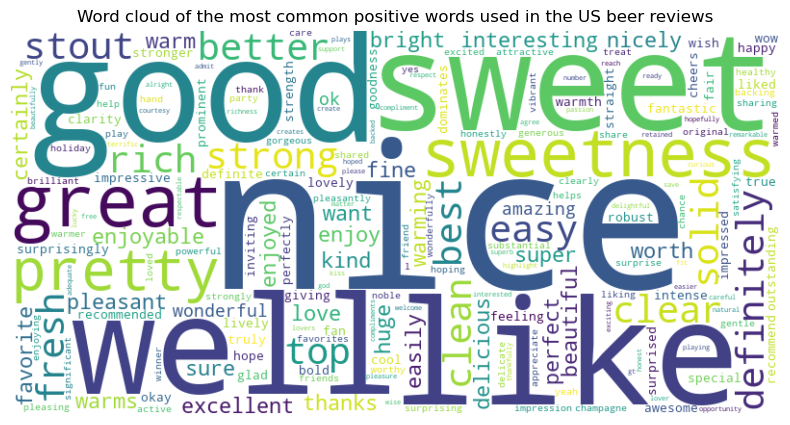

In [82]:
#Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color= 'white').generate_from_frequencies(positive_word_freq)

#Plot the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common positive words used in the US beer reviews')
plt.show()

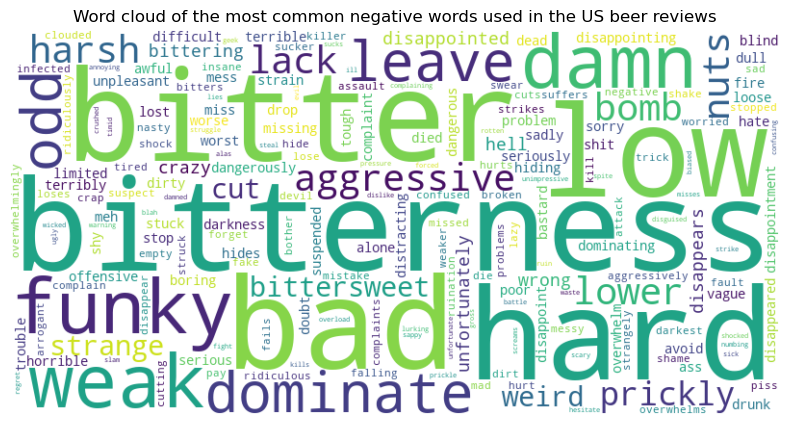

In [83]:
#Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color= 'white').generate_from_frequencies(negative_word_freq)

#Plot the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common negative words used in the US beer reviews')
plt.show()

In both wordclouds, we can see there are a **good number of ambiguous words**. For instance, in the negative word cloud, we can see the word "bitter", that can be used as a positive or negative adjective, depending on the tastes and preferences of the reviewer.

Moreover, the word "low" can refer to something undesirable ("low quality" or "low rating"), which might trigger a negative sentiment. But in other contexts, it can be neutral or even positive ("low alcohol content"  which might be appreciated by some consumers).

We will have to take the presence of these ambiguous words into account when we do further analysis. For instance, we can correlate the overall rate given in the review associated to each ambiguous word to understand if this word has a positive or negative meaning.

## Question for TA

We observe a change of around 0.05 of ratings from a season to another, can we consider this change significant enough to further analyse or should we only focus ourselves on the semantic analysis of the reviews?

# Pauline vizualisation

In [19]:
ratings.head()

abv  appearance  aroma   beer_id      beer_name  brewery_id  \
0  4.5        3.25   2.75  142544.0          Régab     37262.0   
1  4.5        3.00   3.50   19590.0  Barelegs Brew     10093.0   
2  4.8         NaN    NaN   19827.0       Legbiter     10093.0   
3  4.8         NaN    NaN   19827.0       Legbiter     10093.0   
4  4.8         NaN    NaN   19827.0       Legbiter     10093.0   

                                brewery_name                date  overall  \
0  Societe des Brasseries du Gabon (SOBRAGA) 2015-08-20 10:00:00      3.0   
1       Strangford Lough Brewing Company Ltd 2009-02-20 11:00:00      3.5   
2       Strangford Lough Brewing Company Ltd 2014-12-01 11:00:00      4.0   
3       Strangford Lough Brewing Company Ltd 2014-05-29 10:00:00      NaN   
4       Strangford Lough Brewing Company Ltd 2014-02-26 11:00:00      NaN   

   palate  ...                       location        country           states  \
0    3.25  ...      United States, Washington  United States       Washington   
1    3.50  ...        United States, New York  United States         New York   
2     NaN  ...          United States, Kansas  United States           Kansas   
3     NaN  ...      United States, New Jersey  United States       New Jersey   
4     NaN  ...  United States, North Carolina  United States   North Carolina   

      region  style_simp abv_category    year month   day  season  
0       West  Pale Lager          low  2015.0   8.0  20.0  Summer  
1  Northeast    Pale Ale          low  2009.0   2.0  20.0  Winter  
2    Midwest    Pale Ale          low  2014.0  12.0   1.0  Winter  
3  Northeast    Pale Ale          low  2014.0   5.0  29.0  Spring  
4      South    Pale Ale          low  2014.0   2.0  26.0  Winter  

[5 rows x 27 columns]

In [20]:
# Remove extra space
ratings['states'] = ratings['states'].str.strip()

# Map the full state names to two-letter abbreviations
state_to_abbreviation = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

ratings['states_XX'] = ratings['states'].map(state_to_abbreviation)

In [22]:
# Calculate the average rating for each style_simp by state and season
state_season_style = (ratings.groupby(['states_XX', 'season', 'style_simp'], observed=False)
                      .agg({'rating': 'mean'})
                      .reset_index())

# Find the style_simp with the highest rating for each state and season
highest_rated_style = (state_season_style.loc[state_season_style.groupby(['states_XX', 'season'], observed=False)['rating'].idxmax()]
                       .reset_index(drop=True))

In [26]:
import plotly.express as px
import plotly.io as pio

fig = px.choropleth(
    highest_rated_style,
    locations='states_XX',
    locationmode='USA-states',
    color='style_simp',
    hover_data=['rating'],
    scope='usa',
    animation_frame='season',
    title='Highest rated beer styles by state and season'
)

fig.show()
fig.write_html("src/graph/highest_rated_beer_styles_by_states_season.html")


**Winter**: During the cold months, darker and richer beer styles like Stouts and Lambics are the most popular in many states. These heavier beers, known for their warming and robust qualities, align well with the colder weather. The preference for these styles suggests that people seek comfort and intensity in flavor during winter, reflecting the need for something substantial and hearty.

**Spring**: As the weather begins to warm, beer preferences shift toward lighter and fruitier options. Styles like Lambic-Fruit and Wild Beers gain popularity, offering refreshing and tangy profiles. This transition seems to reflect the seasonal shift, where people are moving away from the heavy richness of winter beers and are drawn to more vibrant and playful flavors that match the blooming and lively atmosphere of spring.

**Summer**: The hottest season brings the biggest change in preferences. Light and crisp beers, such as Lambic-Fruit, Berliner Weissbier, and other refreshing styles, dominate across the states. These beers are thirst-quenching and easy to drink, perfectly suited for the heat. Notably, darker beer styles almost disappear in most states during this time, as people prioritize lightness and refreshment over richness.

**Fall**: In fall, preferences shift back toward heavier styles like Stouts and Barleywines. As the weather cools, people seem to rediscover a taste for rich and malty beers, preparing for the colder months ahead. This pattern reflects a return to comfort and indulgence, closing the seasonal beer cycle.

In [36]:
mean_ratings = ratings.groupby(['season', 'abv_category'], as_index=False, observed=False)['rating'].mean()

# Separate data for high and low alcohol content
high_abv = mean_ratings[mean_ratings['abv_category'] == 'high']
low_abv = mean_ratings[mean_ratings['abv_category'] == 'low']


fig_high = px.line(
    high_abv,
    x='season',
    y='rating',
    title="Seasonal ratings for high alcohol content beers",
    labels={'rating': 'Average rating', 'season': 'Season'},
    markers=True
)

fig_low = px.line(
    low_abv,
    x='season',
    y='rating',
    title="Seasonal ratings for low alcohol content beers",
    labels={'rating': 'Average rating', 'season': 'Season'},
    markers=True
)

fig_high.show()
fig_low.show()

fig_high.write_html("src/graph/season_ratings_high_abv.html")
fig_low.write_html("src/graph/season_ratings_low_abv.html")



**High alcohol content beers**:
Winter and Fall are the most favorable seasons for high alcohol content beers, with average ratings reaching around 4.08. This suggests a strong preference for heavier, more robust beer styles during colder months, which aligns with the warming and comforting nature of these beers. In contrast, the summer sees a significant drop in ratings for high alcohol content beers, falling to approximately 4.05. This decline reflects a seasonal shift in consumer preferences, as heavier beers might feel less appealing in the heat.


**Low alcohol content beers**:
Ratings for low alcohol content beers peak during the spring, with an average of around 3.585. This increase likely corresponds to the preference for lighter, refreshing options as temperatures start to rise. Winter is the least favorable season for low alcohol beers, with ratings dipping to about 3.555. The colder weather likely drives consumers toward richer and heavier beers, making lighter styles less desirable.